# Experimental Setup

In [ ]:
from federated_learning.utils import SHAPUtil, experiment_util, Visualizer
from federated_learning import TestClientPlane, ClientPlane, Configuration, ObserverConfiguration
from federated_learning.server import Server
from datetime import datetime
from federated_learning.nets import MNISTCNN
from federated_learning.dataset import MNISTDataset
import os
config = Configuration()
config.POISONED_CLIENTS = 0
config.DATA_POISONING_PERCENTAGE = 1
config.DATASET = MNISTDataset
config.MODELNAME = config.MNIST_NAME
config.NETWORK = MNISTCNN
observer_config = ObserverConfiguration()
observer_config.experiment_type = "shap_fl_poisoned"
observer_config.experiment_id = 1
observer_config.test = False
observer_config.datasetObserverConfiguration = "MNIST"
neutral_label = 2

In [ ]:
data = config.DATASET(config)
shap_util = SHAPUtil(data.test_dataloader) 
server = Server(config, observer_config,data.train_dataloader, data.test_dataloader, shap_util)
visualizer = Visualizer(shap_util)
client_plane = ClientPlane(config, observer_config, data, shap_util)

In [ ]:
import numpy as np
import copy
import torch
import os
for j in range(3):
    for i in range(100):
        experiment_util.set_rounds(client_plane, server, i+1)
        experiment_util.run_round(client_plane, server, i+1)
    file = "./temp/models/ex8/{}_MNIST_round_{}_.model".format(j, i+1)
    if not os.path.exists(os.path.dirname(file)):
            os.makedirs(os.path.dirname(file))
    torch.save(server.net.state_dict(), file)

In [ ]:
def cos_similarity_values(s_client, s_server):
    from scipy import spatial
    import numpy as np
    cos_similarity = [[] for i in range(10)]
    differences_sum = [[] for i in range(10)]
    shap_subtract = np.subtract(s_client, s_server)
    for row_idx, row in enumerate(s_client):
        for img_idx, image in enumerate(row):
                cos_similarity[row_idx].append(spatial.distance.cosine(image.flatten(),s_server[row_idx][img_idx].flatten()))
                differences_sum[row_idx].append(np.sum(shap_subtract[row_idx][img_idx].flatten()))
    return np.sum(cos_similarity), np.sum(np.abs(differences_sum)), np.max(cos_similarity), np.abs(np.array(differences_sum).flatten()[np.argmax(np.abs(np.array(differences_sum).flatten()))])
    


# Test Client

In [ ]:
config.NUMBER_OF_CLIENTS = 40
config.FROM_LABEL = 8
config.TO_LABEL = 0
test_client_plane = TestClientPlane(config, observer_config, data, shap_util)
experiment_util.update_configs(test_client_plane, server, config, observer_config)

In [ ]:
import torch
for j in [100]:
    data = config.DATASET(config)
    test_client_plane = TestClientPlane(config, observer_config, data, shap_util)
    model_file = file = "./temp/models/ex8/2_MNIST_round_{}_.model".format(j)
    server.net =  MNISTCNN()
    server.net.load_state_dict(torch.load(model_file))

    server.test()
    recall, precision, accuracy = server.analize_test()
    print("Original", recall, precision, accuracy)
    server_shap = server.get_shap_values()

    config.POISONED_CLIENTS = 20
    experiment_util.update_configs(test_client_plane, server, config, observer_config)
    print(len(test_client_plane.clients[0].train_dataloader.dataset.dataset.targets[test_client_plane.clients[0].train_dataloader.dataset.dataset.targets == 5]))

    test_client_plane.poison_clients()
    clean_clients = experiment_util.select_random_clean(test_client_plane, config, 100)
    poisoned_clients = experiment_util.select_poisoned(test_client_plane, 100)
    clean_dis = []
    poisoned_dis = []
    clean_diff = []
    poisoned_diff = []
    clean_max_diff = []
    poisoned_max_diff = []
    clean_max_dis = []
    poisoned_max_dis = []
    print("Clean")
    print(len(test_client_plane.clients[0].train_dataloader.dataset.dataset.targets[test_client_plane.clients[0].train_dataloader.dataset.dataset.targets == 5]))
    for idx, i in enumerate(clean_clients[:20]):
        test_client_plane.update_clients(server.get_nn_parameters())
        test_client_plane.clients[i].train(j+1)
        clean_client_shap = test_client_plane.clients[i].get_shap_values()
        distance, diff, dis_max, diff_max = cos_similarity_values(clean_client_shap, server_shap)
        clean_dis.append(distance)
        clean_diff.append(diff)
        clean_max_dis.append(dis_max)
        clean_max_diff.append(diff_max)
        if (idx+1)%25 == 0:
            print(clean_dis[idx-25:idx])
    
    clean = {
        "dis" : clean_dis, 
        "diff" : clean_diff,
        "max_dis" : clean_max_dis,
        "max_diff" : clean_max_diff
    }

    print("Poisoned")
    server.net =  MNISTCNN()
    server.net.load_state_dict(torch.load(model_file))
    for idx, i in enumerate(poisoned_clients[:20]):
        test_client_plane.update_clients(server.get_nn_parameters())    
        test_client_plane.clients[i].train(j+1)
        poisoned_client_shap = test_client_plane.clients[i].get_shap_values()
        distance, diff, dis_max, diff_max = cos_similarity_values(poisoned_client_shap, server_shap)
        poisoned_dis.append(distance)
        poisoned_diff.append(diff)
        poisoned_max_dis.append(dis_max)
        poisoned_max_diff.append(diff_max)
        if (idx+1)%25 == 0:
            print(poisoned_dis[idx-25:idx])
    print(len(test_client_plane.clients[poisoned_clients[0]].train_dataloader.dataset.dataset.targets[test_client_plane.clients[poisoned_clients[0]].train_dataloader.dataset.dataset.targets == 5]))
    test_client_plane.reset_default_client_nets()
    test_client_plane.reset_poisoning_attack()
    
    poisoned = {
        "dis" : poisoned_dis, 
        "diff" : poisoned_diff,
        "max_dis" : poisoned_max_dis,
        "max_diff" : poisoned_max_diff
    }

# Client

In [ ]:
config.NUMBER_OF_CLIENTS = 200
config.FROM_LABEL = 7
config.TO_LABEL = 4
client_plane = ClientPlane(config, observer_config, data, shap_util)
experiment_util.update_configs(client_plane, server, config, observer_config)

In [ ]:
import torch
config.FROM_LABEL = 7
config.TO_LABEL = 4
for j in [100]:
    data = config.DATASET(config)
    client_plane = ClientPlane(config, observer_config, data, shap_util)
    model_file = file = "./temp/models/ex8/2_MNIST_round_{}_.model".format(j)
    server.net =  MNISTCNN()
    server.net.load_state_dict(torch.load(model_file))

    server.test()
    recall, precision, accuracy = server.analize_test()
    print("Original", recall, precision, accuracy)
    server_shap = server.get_shap_values()

    config.POISONED_CLIENTS = 100
    experiment_util.update_configs(client_plane, server, config, observer_config)
    print(len(client_plane.clients[0].train_dataloader.dataset.dataset.targets[client_plane.clients[0].train_dataloader.dataset.dataset.targets == 5]))

    client_plane.poison_clients()
    clean_clients = experiment_util.select_random_clean(client_plane, config, 100)
    poisoned_clients = experiment_util.select_poisoned(client_plane, 100)
    clean_dis = []
    poisoned_dis = []
    clean_diff = []
    poisoned_diff = []
    clean_max_diff = []
    poisoned_max_diff = []
    clean_max_dis = []
    poisoned_max_dis = []
    print("Clean")
    print(len(client_plane.clients[0].train_dataloader.dataset.dataset.targets[client_plane.clients[0].train_dataloader.dataset.dataset.targets == 5]))
    for idx, i in enumerate(clean_clients[:20]):
        client_plane.update_clients(server.get_nn_parameters())
        client_plane.clients[i].train(j+1)
        clean_client_shap = client_plane.clients[i].get_shap_values()
        distance, diff, dis_max, diff_max = cos_similarity_values(clean_client_shap, server_shap)
        clean_dis.append(distance)
        clean_diff.append(diff)
        clean_max_dis.append(dis_max)
        clean_max_diff.append(diff_max)
        if (idx+1)%25 == 0:
            print(clean_dis[idx-25:idx])
    
    clean = {
        "dis" : clean_dis, 
        "diff" : clean_diff,
        "max_dis" : clean_max_dis,
        "max_diff" : clean_max_diff
    }

    print("Poisoned")
    server.net =  MNISTCNN()
    server.net.load_state_dict(torch.load(model_file))
    for idx, i in enumerate(poisoned_clients[:20]):
        client_plane.update_clients(server.get_nn_parameters())    
        client_plane.clients[i].train(j+1)
        poisoned_client_shap = client_plane.clients[i].get_shap_values()
        distance, diff, dis_max, diff_max = cos_similarity_values(poisoned_client_shap, server_shap)
        poisoned_dis.append(distance)
        poisoned_diff.append(diff)
        poisoned_max_dis.append(dis_max)
        poisoned_max_diff.append(diff_max)
        if (idx+1)%25 == 0:
            print(poisoned_dis[idx-25:idx])
    print(len(client_plane.clients[poisoned_clients[0]].train_dataloader.dataset.dataset.targets[client_plane.clients[poisoned_clients[0]].train_dataloader.dataset.dataset.targets == 5]))
    client_plane.reset_default_client_nets()
    client_plane.reset_poisoning_attack()
    
    poisoned = {
        "dis" : poisoned_dis, 
        "diff" : poisoned_diff,
        "max_dis" : poisoned_max_dis,
        "max_diff" : poisoned_max_diff
    }

In [ ]:
import pprint
pp = pprint.PrettyPrinter(width=6000, compact=True)
pp.pprint(clean)

In [ ]:
import pprint
pp = pprint.PrettyPrinter(width=6000, compact=True)
pp.pprint(poisoned)

# Results for Testing 
20 clean 20 poisoned

In [1]:
# 40 clients with dataset of size 250
clean = [
    #0: 2->6
    {'diff': [1.0849075888681834, 1.7261565298275088, 1.2226360173242454, 1.0284949802980832, 1.1785251984338874, 1.738894385945629, 0.5106770698775093, 0.8242061131115497, 1.076824362062779, 0.512109871242689, 2.125673335114314, 0.4139565884616875, 0.6063651559270528, 0.8532511027132814, 1.290870133518869, 0.586846790728158, 0.7012847225818465, 1.1644798735780386, 1.0338550913352216, 1.3276812814844248], 'dis': [16.60028905759742, 20.346169819453923, 22.273474051774855, 16.26981869116338, 18.091265336431032, 17.603118636412788, 19.01669792147125, 16.199546893725888, 16.9003197007041, 15.90977295179729, 21.575652388498256, 16.77801931542461, 20.00234476771878, 18.873837796049784, 18.173384519645488, 16.35368704269265, 14.276129957664322, 16.24297722932624, 19.631751757433573, 17.92020634184806], 'max_diff': [0.07954921324511499, 0.3675001997923317, 0.22498434682537294, 0.1493092811990726, 0.14843408809739378, 0.17258121057545317, 0.09475041104382642, 0.07314532378487826, 0.11736195875985622, 0.03905222066974634, 0.5112868958828014, 0.05700745002660945, 0.05600200203350969, 0.1196631494967284, 0.28826751930606775, 0.05651016065420089, 0.029554467183569355, 0.14099768106648725, 0.11407357976246502, 0.20958483111074555], 'max_dis': [1.4692740295192908, 1.5628968523348103, 1.8306171154860276, 1.161827947297248, 1.5044207195574169, 1.583259942525904, 1.8309905539961298, 1.8810661761020564, 1.622890441378213, 1.4748193128191733, 1.7033641148883958, 1.5672883692464716, 1.8598436271958172, 1.365665485682313, 1.7980973077779296, 1.5373801288867994, 1.44065093199815, 1.4158792011180052, 1.6882274673675652, 1.5300452910763211]},
    #0: 7->9
    {'diff': [1.4679762284216709, 0.9546037765952935, 1.2800099750724439, 0.9880040282885382, 0.7911507251403725, 0.8663243919266587, 0.680224651983363, 0.9707875475748169, 0.8059496873421266, 0.9054494128119324, 0.7952707048201412, 1.6753088355865988, 0.7622519463771177, 1.0042791570549836, 0.6650437732146863, 1.2776049117297013, 0.5598132364301011, 1.378778319790497, 1.001208662987148, 1.080309474623642], 'dis': [16.707212291297463, 15.452468456221666, 15.681168928001247, 19.79977643610973, 18.42679163409095, 18.573960875706337, 14.151592667497686, 16.256577501969502, 21.889423401942942, 19.618770802519464, 19.609906977908366, 17.37457086339623, 18.96301299195799, 17.916843665598748, 17.828039868670082, 20.134089770516706, 12.74105498841088, 15.347724040525765, 18.857397747283578, 21.49982278575075], 'max_diff': [0.3065202141052268, 0.08237012526183096, 0.12990797051685732, 0.07239972524819871, 0.09333619126330106, 0.043030549225885784, 0.05333872997675454, 0.09394684789307739, 0.13917480149607897, 0.10182094918452655, 0.0982080809340502, 0.24231875051013674, 0.12198271646944114, 0.12926402817257698, 0.08912648421822755, 0.2785255818871146, 0.06416540544321947, 0.23047245135090577, 0.10092206203505794, 0.13517090603315784], 'max_dis': [1.8345613310011704, 1.5630403598276512, 1.5873563138612545, 1.9825264411871097, 1.600411514648274, 1.2364716411254115, 1.5047108748956286, 1.2052719657501476, 1.5298601163905308, 1.5709678843263553, 1.6853518292842424, 1.8325804083096489, 1.7467889033355273, 1.3304177694122687, 1.59474420235976, 1.815213074902109, 1.249001333695245, 1.2620310330275306, 1.645157443865857, 1.7262846487819772]},
    #1: 1->5
    {'diff': [0.6800178060417637, 0.47683372684153513, 0.3734858086146356, 0.5661079745385993, 0.7738367590341085, 1.0559566583460556, 0.3247546019803798, 0.6557216687927941, 0.814117816605799, 0.4149797920751319, 0.5281264701374468, 0.9813969115318375, 0.38149292745467406, 0.47031104380858, 0.5628622365800281, 0.4608769200225431, 0.6993639541552987, 0.4238484249948575, 0.7297660029053306, 1.2030224676830017], 'dis': [10.286644757580088, 12.92182869074231, 10.844742967741757, 11.287840282429146, 14.007823833240579, 14.453329437800983, 15.475242302474824, 13.138638237463143, 15.582482482570384, 14.699140107489736, 14.954383933069467, 14.675274429672838, 14.914463214488132, 14.677412745623883, 14.544800073124884, 13.338742029861871, 17.550231414188566, 14.952173524602825, 15.099140385146688, 19.107824523315948], 'max_diff': [0.06079397441970469, 0.057273572206001266, 0.03588011776343336, 0.08801705000399274, 0.0935959957532253, 0.23413142094417339, 0.027628029338786497, 0.12887486376678725, 0.10963995780517166, 0.06684800035577432, 0.048128210490018475, 0.25047307582891776, 0.043374617337416765, 0.05000244216041416, 0.08317551056681438, 0.10300146099688767, 0.13387932008704428, 0.06266865002709032, 0.14692199920367877, 0.24538262416504586], 'max_dis': [1.6326599395326586, 1.9285212383664492, 1.3353192612093028, 1.8393742599526957, 1.5680324969381396, 1.3448430168478995, 1.9191658524475357, 1.3295276004139613, 1.7666326846515825, 1.1966542668118476, 1.9456849813165664, 1.9608222822043557, 1.8970251324256981, 1.6700267917534086, 1.251246589316375, 1.2552591662879093, 1.5767996967648152, 1.7948897540272166, 1.7228261825780078, 1.765683535148872]},
    #1: 9->6
    {'diff': [0.9899015664989379, 0.6918072176667276, 0.5464425111599662, 0.6351946514865255, 0.6496181152417437, 0.5132151923379977, 0.4567123642769087, 0.5503335153111115, 0.6759525312686265, 0.9993314388760507, 0.8451542056539469, 0.6393059946169813, 0.6850079026857494, 1.0193083482201475, 0.49208554731248416, 0.7001151841830031, 0.7766102711119612, 0.38840537218094034, 0.527314880163791, 0.4248600145548898], 'dis': [14.335350878867642, 14.031461528592777, 15.482817830687877, 13.878038259984997, 13.75429948489434, 11.289809188679847, 12.364145199820511, 13.580909259681311, 18.940267314719144, 13.025341716234326, 13.777991976565689, 13.828686456078323, 16.91251195465689, 17.643761391768493, 14.021894833897475, 15.294189730832501, 17.485521524953178, 13.841329691478977, 13.685106792793182, 13.629592578985351], 'max_diff': [0.23703271539073256, 0.07165827313701811, 0.08639034987648131, 0.0591378668438461, 0.09351407560047265, 0.05340628018326399, 0.036236589081022785, 0.07249466069631083, 0.06506096693396668, 0.1347246314883792, 0.09803031744719704, 0.042494997135584356, 0.05389434733571097, 0.252654698335427, 0.05534672423324505, 0.060351374186971896, 0.10038538763417293, 0.04303867610426515, 0.059835210023164054, 0.04294758506959084], 'max_dis': [1.8089009608272004, 1.7142321442763058, 1.8513978471181218, 1.260302202981431, 1.5274262304798527, 1.32099007616129, 1.8984793225714562, 1.7221232504378494, 1.748618994537373, 1.5813421760945534, 1.6946319510242733, 1.8348363431536794, 1.8004329838668318, 1.5151902861760784, 1.7215052714601637, 1.330261370724473, 1.7973687115673727, 1.4764466722379974, 1.9042754684755399, 1.5710014180432674]},
    #2: 8->0
    {'diff': [0.31520688193972546, 0.1886741631259807, 0.5066904571110541, 0.3341570060482464, 0.3803761029185946, 0.18987576730294028, 0.14834785696731878, 0.2846251675615089, 0.36894439088436637, 0.43218076678040973, 0.1848497234636, 0.32216092144888564, 0.2435777211888696, 0.3535302887997549, 0.18381345099672688, 0.20711385525556097, 0.36946651010850645, 0.2512713218916601, 0.2242329347842938, 0.2420614213803166], 'dis': [6.688131970596315, 8.1077066887948, 6.563675928260373, 8.204778736322934, 10.279612598009143, 8.13408576078598, 5.49633099631045, 5.678379207167101, 8.912703092376058, 8.104788495905796, 7.829966251415513, 13.698085406855329, 8.436298257403463, 5.902503467299761, 4.563895690666683, 8.42813806973266, 8.531110032003934, 9.435336306681611, 7.6562550953263635, 9.463128351131916], 'max_diff': [0.030710523997470318, 0.032308570792153546, 0.07564258059276918, 0.031629438433189216, 0.03978674503538571, 0.01581474951411574, 0.019752892651755616, 0.037060093133618466, 0.032381199607483424, 0.026422676263798017, 0.03178951010542619, 0.028045662021071394, 0.02693190167840598, 0.064556522687516, 0.023487163682210405, 0.025356707058417527, 0.05328156834820774, 0.034434770581991625, 0.0273266263717602, 0.02307799375451225], 'max_dis': [1.4529402639771183, 1.660396064240331, 1.2666917673894944, 1.2499864719889069, 1.8484665442199724, 1.2803141763410297, 0.9083654073230522, 1.6582515779066809, 1.4977669857527123, 1.4237977608262227, 1.2855152512165382, 1.8750383772826782, 1.663913132314569, 0.7644746290202827, 1.479886216471238, 1.531833366606457, 1.2942885105931752, 1.4543736223667096, 1.6137794938882544, 1.5837087252594693]},
    
]

In [2]:
poisoned = [
    #0: 2->6
    {'diff': [5.185035737089893, 6.343990485062662, 5.098306433787643, 5.452870947063114, 5.864700202108121, 6.475024462090671, 4.626420381602388, 6.535341591933148, 4.710203197295661, 5.728783064258702, 6.02008238392145, 5.885587019636608, 3.0557766455294013, 5.7820477439297076, 4.674298592701803, 5.497441167341973, 3.9322534783797485, 5.0042706216497965, 4.441994208415834, 5.112275117312659], 'dis': [26.375407864373425, 32.554707288559655, 31.8296039063587, 33.47056596056074, 32.2624061236572, 28.160340992257925, 24.700397039763317, 33.90371021427854, 25.896665374070984, 30.648833553631405, 30.77824239073122, 30.54960757580101, 27.208905969331504, 32.310445758579114, 29.09855648221833, 28.674515461949735, 23.976515774239942, 28.550034466304858, 27.090416980208964, 27.726811810237653], 'max_diff': [0.7988915981241361, 0.8598447213896541, 0.911154546738379, 0.7690640923797093, 0.8930219487154814, 0.8909690664805238, 0.8171510726509177, 0.9090731200349532, 0.6711340910854803, 0.8343145987941514, 0.8723115730942615, 0.8161975164793914, 0.25815926368781783, 0.7614329579889878, 0.8572035788593605, 0.8221708357742782, 0.7913577873749381, 0.7767018104351564, 0.8294618878741357, 0.7561237397004527], 'max_dis': [1.4133539968549407, 1.690139684865374, 1.6822729484821437, 1.6053552973215275, 1.516972260075709, 1.4481100621288499, 1.7049683065348757, 1.4622169919168848, 1.4029544232651139, 1.6226189850847113, 1.8037481443195609, 1.5800754773358066, 1.779771621894691, 1.7830727860533835, 1.5595110926876716, 1.550480128216786, 1.7234337506162938, 1.5200012730917212, 1.3086388455841742, 1.5396615105137337]},
    #0: 7->9
    {'diff': [4.37721001046565, 4.939476347847249, 4.723330279860734, 4.93692433125091, 4.163188906902201, 4.631835250070569, 4.883283623957279, 5.128140685137128, 4.702189125543737, 4.058876522419661, 3.9939904564995814, 4.2451987947703955, 4.334632895185173, 4.340179810706038, 3.730319278222445, 4.236816211118103, 4.191092049692117, 5.17324233421089, 4.671416065638278, 4.511165830953402], 'dis': [20.996319558858158, 22.840539071607168, 22.935493532572647, 21.782725700321777, 22.638062707421128, 20.282200681057432, 22.657536701863634, 20.407875658765107, 21.42913915640137, 20.03853552392433, 21.085872846045483, 17.88902900800042, 18.162192256255352, 19.366203273929774, 17.9428475456969, 25.89114619823951, 21.93877976254115, 21.96148104475741, 19.163656437067356, 20.506901415853875], 'max_diff': [0.6754280573050918, 0.6697052174243457, 0.7007336146267119, 0.7447515965918414, 0.6534322681384159, 0.7414960335323508, 0.6963030891208067, 0.707171195041174, 0.7110815480557141, 0.6279478542867584, 0.6932617597462941, 0.6077713409576747, 0.6690651485655482, 0.7137587158194204, 0.5764683818644024, 0.6726413148306466, 0.6683661842373475, 0.7230787791471246, 0.6518418019910938, 0.6769799228774743], 'max_dis': [1.5235958272718397, 1.3746211895188387, 1.3747645468794967, 1.7098204077823778, 1.6093517409901903, 1.5166439408695958, 1.2158682775557432, 1.394601644527431, 1.4460908876444116, 1.6768580202468875, 1.5989864143315584, 1.4116059412057584, 1.3947205246798875, 1.5914371821235864, 1.7399812265092305, 1.7089008695350842, 1.6309892966417345, 1.4102134571731808, 1.4227864753857533, 1.6497615166479214]},
    #1: 1->5
    {'diff': [4.450622933776092, 4.074067318629603, 4.374795393416425, 3.172739633712344, 4.226081963686648, 3.9882875014059875, 4.076916416606195, 3.9569965796316424, 3.512735719533262, 3.8596097845528767, 4.156082114314521, 3.753977024397234, 3.294553350834804, 4.254123353570074, 4.152065677365579, 3.564684208859989, 3.382488205432895, 4.542112515152915, 3.8698023969524398, 3.9009794070570547], 'dis': [25.984481382450713, 25.42360666515736, 31.2747293800059, 27.934457553573207, 31.484924777532356, 28.813180764085985, 25.178573091466113, 33.74226170693204, 27.05668124976845, 25.890879243430433, 25.207416548276534, 29.558205643474764, 30.393177431600783, 31.208178787132102, 30.30847121844654, 28.234332198258556, 25.667619854192626, 26.58875494965064, 27.092315540358733, 31.506095657498484], 'max_diff': [0.6473616785671039, 0.5926107417305218, 0.5989728846449669, 0.41595121187718576, 0.5096682735143556, 0.717838321780461, 0.5628977481171997, 0.5080713289650873, 0.5954011291978771, 0.6345244709911411, 0.6049104752622152, 0.5809848109191542, 0.4857851771603183, 0.5785122089882888, 0.6200691369996068, 0.51175744340948, 0.540459785029876, 0.505670306555448, 0.6422551412683246, 0.5738553471742617], 'max_dis': [1.709989197044263, 1.7082055985612405, 1.7681640013193247, 1.7948426386753442, 1.7480647350052239, 1.5915004717259382, 1.3800242009364856, 1.646909267320604, 1.6894825362505326, 1.6908998945439584, 1.8203022719139446, 1.7629229725425581, 1.8081513171585304, 1.7543493308271239, 1.7342870052312516, 1.741380768955521, 1.766587074355687, 1.490309433644719, 1.6573054437813508, 1.7988766989458012]},
    #1: 9->6
    {'diff': [4.865152703107075, 5.406363453763829, 4.038876683969205, 4.459463221988414, 5.379500629835075, 4.947671020199497, 4.541384251022676, 4.922590956015295, 4.542686154557012, 6.056835968734979, 4.485299420881332, 4.771343490441854, 5.074708941257938, 4.795623142795346, 5.170579747021443, 4.72118329085727, 3.842377208949165, 5.148787303053486, 5.145477933472367, 4.579367212886901], 'dis': [32.45905024188109, 33.925196200392115, 29.46378837003655, 30.789908446786676, 42.38886618399491, 36.74787389262267, 28.94519404973798, 33.00922182304059, 32.565186215313226, 35.62301039949287, 31.31119608084372, 38.75297930001947, 34.284247632829874, 29.474802959678506, 38.301383091079266, 37.82279733025318, 33.88940590779339, 35.77048869277805, 34.47670987685757, 35.14894869212355], 'max_diff': [0.582192905760273, 0.5959136335713864, 0.5918857336512762, 0.5493625193128162, 0.6047008784181189, 0.5914748234235252, 0.6131687565828489, 0.6029416018300284, 0.6151151973939091, 0.6572203258137144, 0.5823198302640726, 0.5404818324758525, 0.5753279242951337, 0.5822457485306458, 0.5654906715535715, 0.573210493701704, 0.5798939900815592, 0.5832757909658006, 0.6268012788528363, 0.5771089262620919], 'max_dis': [1.4113601833216378, 1.4184554683804205, 1.4574214991460233, 1.7970636541669693, 1.4774213315899465, 1.6003024142125937, 1.6184449191829775, 1.4605922455422542, 1.657589678568373, 1.2804337473087486, 1.4974310477159098, 1.816630105078345, 1.2990810615312793, 1.4344008909048553, 1.5727958281041121, 1.5844009072411076, 1.9186112025238091, 1.455159215834797, 1.6292388997592204, 1.500495507925757]},
    #2: 8->0
    {'diff': [2.4388820290729187, 2.677501137942425, 2.640531858389733, 2.707702405071677, 2.6968742945040995, 2.6393111228765505, 2.9221334469928477, 2.97659716038589, 2.629442032476202, 2.47546023293699, 3.120586132193818, 3.113034800273066, 2.5130172604342715, 2.9380997262984234, 2.2783748079099624, 2.6880752450859062, 3.0553443337037343, 2.618531280345874, 2.668433376864439, 2.541816155210806], 'dis': [13.844996578434001, 16.779375883623548, 19.016513802470243, 21.100913112521233, 19.63178767774332, 18.723050103871778, 19.566601677102266, 20.87575133024394, 22.793474034471835, 15.97485029702683, 19.64560356216489, 18.72709088539321, 18.973313885345828, 21.94951639357543, 15.831858481653834, 23.186242704764386, 20.72726330142623, 20.202643795536215, 22.024980826426752, 20.929454351290623], 'max_diff': [0.8055377540402091, 0.8894967236360187, 0.8636922096701405, 0.8928013650468762, 0.8248003800437639, 0.8767451412477291, 0.8536944912661415, 0.8036024669629809, 0.8024433790764431, 0.8309078266563059, 0.8692775087783899, 0.8865805435093796, 0.8469217963396634, 0.8320728231337904, 0.8149649441007711, 0.8178122174741032, 0.8352987915553935, 0.8708037937209272, 0.8193291738037987, 0.8686304148868128], 'max_dis': [0.964904118419975, 1.409086562413194, 1.4367061153295648, 1.5670436528583997, 1.6565668459054124, 1.4234975143509836, 1.5706805826253385, 1.6366206601990352, 1.4405268054428364, 1.1858823476655806, 1.4917206697429948, 1.6183164996932482, 1.2151211397517345, 1.5420667444979057, 1.3881143230048376, 1.5789422611410497, 1.6925915597843244, 1.3655299670293763, 1.3533787406910112, 1.8329002091035802]},
]

In [3]:
clean_test = []
clean_test_label = []
for idx, data in enumerate(clean):
    for i, d in enumerate(data['diff']):
        clean_test.append([data['diff'][i], data['dis'][i], data['max_diff'][i], data['max_dis'][i]])
        clean_test_label.append(-1)

In [4]:
poisoned_test = []
poisoned_test_label = []
for idx, data in enumerate(poisoned):
    for i, d in enumerate(data['diff']):
        poisoned_test.append([data['diff'][i], data['dis'][i], data['max_diff'][i], data['max_dis'][i]])
        poisoned_test_label.append(1)

In [6]:
X_test = clean_test + poisoned_test

In [71]:
len(X_test)

200

In [7]:
y_test = clean_test_label + poisoned_test_label
print(y_test[:5])

[-1, -1, -1, -1, -1]


In [8]:
from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test,y_test, random_state=0)
print(y_test)

[-1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1]


<Figure size 432x288 with 0 Axes>

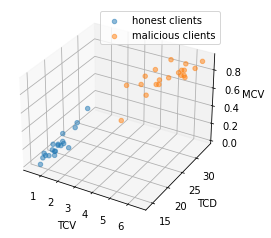

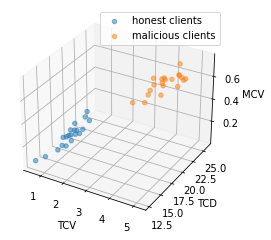

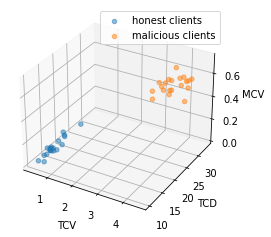

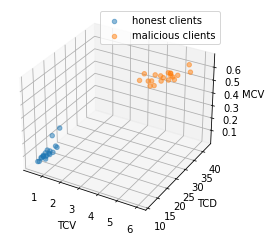

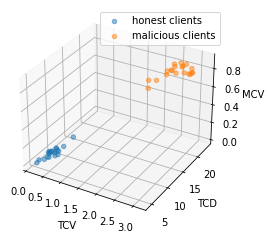

In [162]:
import numpy as np
import matplotlib.pyplot as plt
i = 0
for i in range(len(clean)):
    plt.figure(i)
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.set_title("")
    ax.scatter(clean[i]['diff'],clean[i]['dis'],clean[i]['max_diff'], alpha=0.5, label="honest clients")
    ax.scatter(poisoned[i]['diff'],poisoned[i]['dis'],poisoned[i]['max_diff'], alpha=0.5,label="malicious clients")
    ax.legend()
    ax.set_xlabel('TCV')
    ax.set_ylabel('TCD')
    ax.set_zlabel('MCV')
    plt.savefig('tcd_tcv_mnist_ex7_{}.pdf'.format(i))
    #ax.view_init()

# Train Preparations

id: 0 -> 1,7
id: 1 -Y 5,4
id: 2 -Y 3,8

In [5]:

clean = [
    {
        #base: 1,7
         'diff': [0.9509264752588411, 1.1701527020493743, 0.8842063710692791, 1.3895195204269304, 1.2277153214988852, 1.7199827155056497, 1.4461499083784812, 1.095177829029705, 0.8066294975182582, 0.9943175014458874, 1.1735635038308914, 1.1097720447942812, 1.0565538309395692, 0.9349513338555371, 1.5653359060346612, 1.304143521880629, 0.8083238384333258, 0.9989016917845455, 0.78796368954239, 1.3328698182515637, 1.127352635657513, 1.2145958206746952, 1.3786046750471193, 0.8325851312909095, 1.227920192289262, 1.1046933334634086, 0.7993648619089989, 1.4999742035838142, 0.9002796557614451, 1.0610358260590915, 0.9892095050497522, 1.2484187564028733, 0.9208532686308613, 1.0894032847380881, 1.5707226829042802, 1.5868118750877023, 0.9541116832119154, 1.2023453451483896, 1.5365413962739245, 1.7826169036150215, 1.3778401298530625, 0.6411570738737843, 1.182307037503977, 0.9574103424014571, 1.0861097859414808, 0.9788033825597844, 1.3336480311375123, 1.3387367645932087, 1.3803849439152507, 1.2005867584603815, 1.1222049566324743, 1.2004304861785686, 1.2998730195663506, 1.268783287983715, 1.4267352713816572, 1.627377097188496, 1.098721339537608, 1.1592458101112122, 1.083079460045392, 0.9893392546285984, 1.2965900013973695, 0.8964434535521562, 1.066939462662484, 1.4037425200263955, 1.2209009323173887, 0.9311876558151191, 1.6965198963665642, 0.7561036394782455, 1.1261189177590174, 1.067988105326716, 1.039271599023742, 1.7535724005365374, 1.2467314204402768, 1.0740835686488128, 1.237649754433455, 1.3645559232783055, 1.3680972088968761, 0.6079498354254733, 1.1963581787398583, 1.0822652837657587, 2.3189195284273847, 1.0881109228858121, 1.4655053786694356, 1.9767371124266053, 1.192087263898919, 1.3233630881882146, 1.2427849150918289, 1.0294440857243679, 0.5085394099669106, 1.7049970372035332, 1.2018794246692395, 0.8691961353862996, 1.5323768223370329, 1.3503595608767736, 1.5879291365383303, 0.9118703297887362, 1.0694817382517097, 1.6323373493097795, 0.5468694216297132, 1.2500412588805312],
         'dis': [16.294952374551965, 18.297547846861647, 17.916037581573804, 15.228031335637112, 16.935860226068034, 18.054253132002238, 21.614657924975056, 16.976328075637813, 19.19932340687958, 23.31615105486116, 21.09877428806215, 21.038389482919058, 16.761962164730793, 17.806734351296118, 22.49474737762674, 20.092634510204554, 20.16896911351645, 16.51780529794623, 20.033792188745473, 19.55088163037298, 19.421899721927062, 15.935469751185783, 22.441360851744058, 20.042322365319773, 20.652650528996798, 16.57467554516548, 19.428559733112746, 21.009312978714714, 18.639597920700744, 17.80697789278306, 20.317537858122105, 19.88956871482109, 18.431084023463615, 16.413931380530375, 18.302636437137668, 22.210337719483288, 25.276095256550555, 18.107090565225374, 19.72706876095098, 21.864320167586847, 18.54421258740827, 16.548842484098277, 16.43137066038857, 18.076836664787137, 23.052934678074912, 20.604583534662762, 20.071507689839667, 20.48337383589349, 22.077039524801055, 14.581952949342167, 20.340400283972762, 20.958994093143858, 23.8571309604286, 16.226260506332444, 18.198524748709698, 14.433848007424523, 18.81105894074947, 16.862523339420047, 20.427311822953193, 17.410044865508112, 22.090177052427432, 20.806648601662847, 22.158527942612533, 17.72036465651003, 17.51261149188131, 20.019971637912647, 18.869635070986767, 19.698342972060864, 15.0788316098738, 21.514067679529507, 20.446749698727256, 23.215898195394704, 17.920911588800013, 19.812586002476166, 19.49765405580162, 17.97954706506214, 16.30505836659457, 19.371174007547346, 16.948121207293585, 21.642854489223616, 20.458009425170154, 20.66159242996497, 26.895862411458133, 20.094927852111933, 20.39430577965392, 19.618693596786663, 24.31030329955234, 20.21934397607769, 23.09929190074525, 19.562503902113566, 18.933948645726353, 19.06290637569486, 22.044244188065136, 20.01776636375022, 16.650358639235098, 23.13408826557383, 17.64343734400898, 20.09574064782531, 19.335079321335193, 17.964964415547556],
         'max_diff': [0.05270333448687259, 0.16427761254089113, 0.09144533297369384, 0.17841813864535894, 0.12048832513928476, 0.28850849456157235, 0.21521841102426986, 0.10584015572227123, 0.06196516850300471, 0.10092049341969656, 0.14415711985140334, 0.1429168550881048, 0.1700232126487936, 0.10861407917966304, 0.3761598512263795, 0.22674980394557886, 0.075645170666931, 0.11783492758724279, 0.07224665880448078, 0.12635579646950035, 0.10462674445813802, 0.14231778957886476, 0.16355742796623574, 0.11858000000041224, 0.13028879884762334, 0.1658170815247626, 0.08138158047341548, 0.19454356138614237, 0.10114576287750277, 0.09597933109808565, 0.11429371197522409, 0.18430511293621965, 0.13004843755352447, 0.16003807620513655, 0.2018027583957771, 0.17722512133276658, 0.07503303118974536, 0.22987888637359433, 0.2046434651301341, 0.29936657639803954, 0.2597974226780124, 0.08917529844192806, 0.2071180886760451, 0.11708314504871886, 0.08170900742946952, 0.19884786820828637, 0.13887465858754755, 0.13775763476716563, 0.18111552683184318, 0.15191128822532107, 0.13022418378548384, 0.10319408836901012, 0.2211335758700308, 0.16420790818040842, 0.252667095836939, 0.3299822623094091, 0.2436290189256134, 0.12735399926029256, 0.12550952935250947, 0.13573256064249328, 0.20826800064802686, 0.1134746756928049, 0.12041724107185203, 0.2165735188420097, 0.15567821131488468, 0.11432464867631964, 0.22187160104672898, 0.09967906628073653, 0.18983814087508755, 0.17974981726320394, 0.18581952294647586, 0.22468818154934223, 0.21784129767794802, 0.059705702201456656, 0.25412952350760043, 0.1937861305163633, 0.1661902981168435, 0.06125243266847469, 0.20185975060027594, 0.13971849370156342, 0.31107773270493255, 0.11901359617173046, 0.3240775349389473, 0.2438004794676476, 0.14045794474257, 0.20928146306463624, 0.19336541197081125, 0.07150970781988875, 0.05559402091189369, 0.20665455862341753, 0.17873664654569277, 0.1241555789786537, 0.17653186886214378, 0.19291320820893576, 0.242089480444462, 0.10864276016499375, 0.16946988609652003, 0.21000562383889676, 0.05263744091139788, 0.22627790061487296],
         'max_dis': [1.889199447054481, 1.6141839452590325, 1.687831581379402, 1.78549763330898, 1.688329711219208, 1.8008696168495375, 1.6549459096708763, 1.7889084433674511, 1.8300988968605982, 1.7948256665154163, 1.6313079771511, 1.8926389851781489, 1.8398530488229388, 1.9648063484805387, 1.8380640882741885, 1.7972547373336893, 1.8205964568276096, 1.736526672735571, 1.6948374923450598, 1.5911457240525542, 1.6702892970820615, 1.7007560516794296, 1.8194699161828503, 1.7548907503479811, 1.7746790397975116, 1.7943105050524921, 1.8171343508049822, 1.8271641677187067, 1.8857181150825992, 1.9290488479456829, 1.9091015741980923, 1.882840836255859, 1.7714665972972836, 1.7289931308359137, 1.6684320331552098, 1.5190342279598705, 1.8937505729626225, 1.5651890394790762, 1.7384527283258673, 1.8058001780259354, 1.5821070461020441, 1.6992664526105483, 1.5852914350175793, 1.7379595811481845, 1.6083800429704418, 1.8022286676646355, 1.7567061264508275, 1.8073282712449679, 1.8602207773106807, 1.6559154585395781, 1.7297631552660904, 1.7815070717420478, 1.8299176646352873, 1.6751181307738423, 1.858973430276472, 1.8291461704621819, 1.6372158918749316, 1.8253556098700967, 1.9859926215832369, 1.6952504694628128, 1.7460776547740067, 1.7390034845258722, 1.7576908343491766, 1.8243804888979, 1.8649140719402237, 1.9449238674372307, 1.8157329958698027, 1.7555166838065674, 1.6270852474130957, 1.8428425267434805, 1.9541938104144005, 1.7388389492495568, 1.6822363925464177, 1.8249508521955335, 1.8956030426174144, 1.6504724552905086, 1.8460896831591274, 1.962820933378798, 1.8096727247633884, 1.7847282555108874, 1.9177740261170189, 1.8569593467248238, 1.7357080655759227, 1.7819512023674517, 1.6489333089602813, 1.7782563743972575, 1.8128566783119497, 1.7396044860228348, 1.9217309857122014, 1.3290794973321933, 1.8107599231176827, 1.5724733613319042, 1.7957901291748255, 1.8706856473234756, 1.78971458403938, 1.704278834773015, 1.8024472529757352, 1.6751987336481808, 1.6525867050929128, 1.7553306558960062]
    },
    {
        #base: 5,4
        'diff': [0.6979951858046373, 1.1600840457301187, 1.0599670209693501, 1.120558572732063, 1.8891695561439605, 1.096668649496423, 1.6416889543069724, 0.7720234089375275, 1.4753864250536384, 1.5866979546527462, 0.8971889688449262, 1.3643551657848318, 1.122821996363088, 0.8149062244280838, 1.3483045893453909, 1.2013048637519252, 1.179863551207645, 0.9200904200070597, 0.8369434909380109, 1.1319645047000857, 1.771421805998886, 1.2722970695034108, 0.9976409210994002, 1.1493052769750187, 1.4704229043927528, 1.999798933829113, 1.2327504475954347, 1.107871648652858, 1.3584268436614868, 0.9372806530960106, 1.1468063003242421, 1.10146657920408, 1.523312799265331, 0.9610594959121888, 0.6744371170482608, 1.387752095306748, 1.182143260699763, 1.0906318063270897, 1.3520100309222807, 1.2283932697340827, 0.8976542329327667, 0.6436976537662547, 1.1747715113722963, 0.7927451465220733, 1.212701627057457, 1.7529271346043624, 1.1523983139977547, 1.3122735878174865, 1.0882205421358457, 0.9475082772015685, 0.8510223277896194, 1.2060419811345635, 0.8254715053970239, 1.8614908331838964, 0.8244335605027743, 0.6515542682757339, 1.254849488043742, 0.9185132347200132, 0.8279719651206847, 1.623148551174852, 0.8966649869567845, 1.287024245432089, 1.3499620091319446, 1.142743956185905, 0.9855157912470974, 1.3129718893708542, 0.9101856010486988, 1.192594681765347, 0.9186017283673423, 1.0528018691598016, 1.3117390811185987, 1.6646709048031045, 1.0661902967799333, 0.5080921248535956, 1.185887124403127, 1.227375873953305, 0.8860561518001953, 1.0677291969899358, 2.219846321956153, 1.2231632063622209, 1.108992065446674, 0.7954050386727601, 1.198714820804042, 1.3180532596884487, 1.2285487929124432, 1.3909457806393517, 1.4605672632914173, 0.996552010857698, 1.5357840296073033, 0.6209076633728453, 1.4134195474526674, 1.1015892324632406, 2.0165139687204534, 0.9792003619101975, 0.9794121204824232, 1.5429379189203156, 1.7121430465598433, 1.209517451072971, 1.1282586618536068, 1.3043329368497347],
        'dis': [18.95599147495248, 24.955194679945915, 17.825647482954437, 15.618839537595209, 18.445652240033045, 12.281953618209858, 19.923431473396274, 20.125551659200337, 17.780026005322398, 19.531759997161366, 20.927162048469718, 20.107359698322465, 17.37119833119551, 20.857350350612236, 18.333139318939967, 14.777869631908468, 20.312519826069035, 18.19216820039226, 20.70030931374765, 15.871293952617574, 23.200391109412145, 18.590992305879308, 20.66719746488429, 18.871373429845285, 17.71096370461268, 20.964463042994737, 20.072901059717434, 15.553464742225328, 22.29267396119052, 21.68068519523111, 17.986074681095435, 21.58329011116437, 21.553467005842712, 18.32388502668919, 23.05189880337465, 20.827028822482237, 24.17057156365615, 12.681651633969883, 20.172262856936182, 18.14892291055335, 21.64246882606478, 18.687044208940065, 19.346643853590628, 17.445068265929745, 17.875648796578766, 20.544872529225483, 19.811938214600552, 16.523971471823298, 19.934582031494784, 18.01144588255816, 16.62873567687794, 19.87753972079399, 20.969579129268606, 22.681955958940154, 18.189510015269544, 14.17048578728533, 20.69699920839011, 19.033376465547683, 17.49415036661661, 18.248040555493795, 20.110509579431575, 17.11650061425976, 20.087666747479, 19.81543776791215, 16.878377908000616, 21.991374739411818, 19.092020622427114, 18.043072872977508, 15.289392647359069, 23.06601089715033, 18.78493247004826, 24.738699959560513, 19.404371826247335, 19.997382801651852, 18.198855582555947, 17.97102071654103, 19.024572313629243, 19.92209517882443, 24.518959906117974, 19.200939830247286, 18.983766082260924, 20.940407600798842, 20.305311418600766, 20.24151805610829, 20.119040518452774, 26.553769166680894, 17.808837130698027, 16.16968176437472, 21.58264989747679, 20.04299949771107, 18.938232389513324, 21.77859942487024, 20.684041309394168, 15.523623040481986, 17.75097479307413, 21.493390322966487, 19.392915179255557, 16.195680359241866, 20.598688848952946, 18.469192132493088],
        'max_diff': [0.06519409090473083, 0.2777583934340804, 0.10831775469879901, 0.15160207772681922, 0.16934003598820446, 0.17379101075333203, 0.1914539207963024, 0.09711870323423533, 0.1325818155786589, 0.18852413083644493, 0.1959699235633201, 0.2220014159282968, 0.17565027987284498, 0.1117832069648319, 0.17587973185773453, 0.13684812073735664, 0.15943459275227134, 0.1949599486972664, 0.08218138496176763, 0.15666109994321253, 0.3331874137139388, 0.167123389568973, 0.13036007666743288, 0.13033587029633242, 0.34905314904698415, 0.2719217217901613, 0.11058194385075382, 0.18939450973940986, 0.17715697146314913, 0.16218900143537596, 0.1805761719816399, 0.23473218378405036, 0.3602969733678485, 0.14177743184882097, 0.05326484616806848, 0.11453026099461683, 0.13010447085907373, 0.15225207639596583, 0.21380142723338302, 0.16967444174600566, 0.09688431267954911, 0.06793604272989384, 0.15651085051545532, 0.08811704887310645, 0.16127790742909376, 0.25891551884276476, 0.13337525249050852, 0.20134958702728056, 0.12678985455168768, 0.15125223380107844, 0.10799621707138574, 0.17385509408242328, 0.1110347579142239, 0.21202345381018128, 0.09059334247060669, 0.08131475977090119, 0.10947659295439571, 0.06947043099905059, 0.13095425277117023, 0.29301688214582633, 0.11001666049561232, 0.19649505169262144, 0.15022595708665776, 0.14289869768927943, 0.1358151603914708, 0.17580780359403025, 0.1214576897621571, 0.21920428188020935, 0.13624350917069705, 0.10442296870340195, 0.23388089031828585, 0.17681323844491814, 0.10741510589018866, 0.028496368858505594, 0.14330194085993142, 0.13150807261872655, 0.08845622967497757, 0.14061582880052015, 0.21153782371711927, 0.16808879146957523, 0.15138840497749229, 0.08581745279686359, 0.28820892088299743, 0.17615256092166298, 0.20069701648760763, 0.1996797337199303, 0.3419397254174221, 0.17215811452560548, 0.1591775245085323, 0.11038543463387906, 0.2161698543015298, 0.17042214314279747, 0.2779843923547394, 0.16571206447666764, 0.15166721202849498, 0.1820645534803642, 0.25495543447529423, 0.1909291427174562, 0.24602191709372878, 0.14571465470093692],
        'max_dis': [1.7592299041230204, 1.9267850475635435, 1.5946148642217894, 1.5199614007384121, 1.8063557886447392, 1.1943150860109295, 1.6239257137608543, 1.728519783483804, 1.8185507324717796, 1.7274321585589265, 1.7658087823224977, 1.5967209747227393, 1.8224599612816372, 1.8073466754570156, 1.8109433788818816, 1.3489474283227751, 1.6421964533764246, 1.6550051259814016, 1.6851966119055035, 1.7877051650273446, 1.942320404416106, 1.6305893087906047, 1.884317631889059, 1.4634513513971865, 1.8378745537206094, 1.5914569863912522, 1.7755106502273839, 1.719175641999954, 1.70007543733101, 1.5401015378935126, 1.6624912824283489, 1.7343464725843114, 1.8825996448263964, 1.7874434081699144, 1.8736602703190401, 1.7516252624002049, 1.7291397932108126, 1.6361481848547603, 1.9097679499396683, 1.7942713947495472, 1.7917045585499238, 1.8390509785398188, 1.6906434002632167, 1.8235110375096633, 1.7500115686970723, 1.8207448961739305, 1.7946010741136769, 1.7963562726436297, 1.8355472759291744, 1.8937780400357958, 1.5948816256948017, 1.6059753695819579, 1.6294277906586294, 1.684684742834651, 1.9238113558221541, 1.710772739943773, 1.5275671897743632, 1.926660693329727, 1.6903247572678568, 1.696214795703772, 1.8756640159414033, 1.6821073244036684, 1.636618074038902, 1.686638060232706, 1.7572566952195374, 1.7842538333952505, 1.654042224832379, 1.8194081971601817, 1.7331484606087937, 1.6773741821362889, 1.637991791418611, 1.7959318562030548, 1.7926697243182939, 1.837879247832209, 1.8224351239024752, 1.9205619982323228, 1.5624510081443836, 1.7312977754272831, 1.6217915113653771, 1.6797670465929297, 1.7245138674517473, 1.8614986301033123, 1.843206987240162, 1.6971612313448237, 1.7431567097420877, 1.7442580014989, 1.894614931337531, 1.7321056437289624, 1.6381862249451906, 1.8990207179770755, 1.7078747349702208, 1.8226989029556984, 1.7836505422673943, 1.8015332435030356, 1.7189365362295015, 1.7173698290289436, 1.727971638381545, 1.7604606799037286, 1.7800631505130893, 1.6483943209879741]
    },
    {
        #base: 3,8
        'diff': [0.6633873930856102, 1.0323399182147122, 1.0516210630335632, 0.5827687656117053, 1.4623795216739777, 0.7263965098683743, 0.6677118209243585, 0.7456121382634658, 0.6842120236088863, 1.4424620763281681, 1.576993231884808, 1.3521888985980914, 1.5570048251377049, 1.2074823305945057, 0.9154437713262125, 1.3610847716914511, 0.8174158031731882, 1.0274446284162828, 0.7115386128128637, 1.3212946757635928, 1.0712023337206227, 1.2577817601184487, 1.412887035518747, 1.0984166856316118, 2.201627087737092, 1.0338549820214116, 1.3088756239566104, 1.5039355433383736, 0.9997456826917023, 1.1648831256143959, 1.0544449378368372, 1.4101974027543704, 0.8090811487959471, 1.2742144684429006, 1.5085113248033464, 0.9257820314557704, 0.9548976605769518, 1.6984789366019721, 1.1211888876768934, 1.7285291895305153, 1.2107672704819972, 1.5223410880754888, 1.6840484905238653, 0.6851265244526191, 0.9096266359026743, 1.859776132352248, 1.001439081637975, 0.6765615208964901, 1.0696522068233487, 0.7554157671885359, 0.9992097286032828, 0.8856855407841662, 1.554663143037402, 1.4427316586594712, 0.9724435770441955, 1.6408029867259073, 1.1245639572222115, 0.6662988087034608, 1.4513008893211987, 1.4335800380320611, 0.9630030787056917, 0.5819665443835549, 0.6770826992958884, 1.2029888844043555, 0.736390415531842, 2.5015810411391857, 0.6591582932455251, 0.5781590644361678, 0.9419069874835329, 1.1166263376007213, 1.0826880374265249, 0.7714108874007684, 0.7739274177411253, 0.9938686736332712, 0.7392953099230851, 1.0557826057545854, 1.41987954701238, 1.210810379419478, 1.5507479473556671, 1.1548347172373825, 0.915399984380024, 0.7199497858356478, 1.0340237458827615, 0.7882709135121168, 1.2691306200538803, 1.0507417881936962, 1.223124544071815, 0.9030190039097015, 0.9556008728218773, 1.833436322847573, 0.9346515782803433, 1.2684155626792553, 1.5678712520997709, 1.2601826864529024, 1.9580422388284973, 1.0894057923683906, 1.20125003842589, 0.7642509939555999, 0.8694255308784244, 1.4088694349188633],
        'dis': [20.03567657130793, 23.474293402265324, 17.063825270164983, 17.297454474360176, 27.841613066110188, 21.8950882293182, 16.334354161036853, 21.543649383592644, 20.580149828327038, 19.326391443615027, 16.5176892085189, 22.016910976057993, 20.01311122672848, 20.88691084239878, 20.420044646808705, 22.42105992554123, 22.097424790991422, 18.504621981456427, 18.122338193457573, 21.894176922055053, 14.935268869623304, 15.113988122787703, 17.995218442409403, 20.81879281163194, 24.97977832954254, 16.22426323910628, 18.57557043199476, 19.285429351398328, 17.5374231694008, 14.497812759113042, 21.21729426293699, 22.243120797701142, 21.992373836238468, 19.507531590903888, 19.570684266512576, 17.811047764331974, 18.81538072445007, 27.300856938988485, 23.195118248555477, 17.461181202627085, 16.131540667405027, 24.141683745352932, 16.993995524535357, 15.919022655386012, 22.077775776350652, 25.13702638727746, 17.702470033674732, 19.41810700379795, 17.8633662496561, 22.85202229251436, 19.395217326332293, 14.816128165803745, 18.350883596477924, 21.6083181460037, 19.15285134644113, 24.79593394821375, 21.908879477090164, 14.898145978332483, 21.50928956440026, 19.44669633672057, 17.589230943769298, 16.81099536384422, 22.30172606240706, 21.50585318993593, 19.66791736078786, 23.31014210154374, 13.86043035109234, 17.09625422399343, 20.18614744962774, 20.4340532059609, 18.393440527909995, 19.473019967438443, 19.437290822599568, 22.701038600294346, 20.73383730941254, 21.635518341923582, 22.491897319890654, 18.54180267820736, 18.566648357774334, 19.854426174493714, 19.459180738075332, 19.80079342639575, 12.992562065110796, 17.16879174989934, 20.510281773865334, 16.780094144590734, 22.042672772851624, 17.94362882783837, 18.24596646797537, 19.84922877249651, 21.817125774543936, 20.138026697728286, 16.661963081131294, 18.053751884782937, 24.396029546247295, 22.629760704967516, 22.046962409625692, 19.829864471847415, 20.302236038243606, 17.61425276521316],
        'max_diff': [0.06911875095236031, 0.21155342252194664, 0.1486934599316232, 0.059683552719861144, 0.31230321527401017, 0.09963709853225211, 0.06428043402451111, 0.1229942785921283, 0.053213815579558954, 0.23466030125686999, 0.21343430108834127, 0.1954863321868192, 0.25703833757858474, 0.2088870773844551, 0.16231302918809654, 0.23042966300744538, 0.0925979521101592, 0.2283210236004436, 0.11498132396746108, 0.153460900095439, 0.12462235578260739, 0.17939052251282916, 0.10808805409106093, 0.15124443808684518, 0.2836177835463509, 0.11578983118076958, 0.1900447573919788, 0.09333474494855665, 0.1423692846333502, 0.1715620047272406, 0.14237518262882265, 0.1592855312506556, 0.06699450032290422, 0.1419787467655791, 0.213267194482901, 0.13757157445185797, 0.09268134364423364, 0.20100173597220206, 0.10099540679597308, 0.25304323377347915, 0.17783728637091478, 0.1895028217241781, 0.17171520923802852, 0.07683944930681097, 0.10192639229564326, 0.30022074636574914, 0.1390700900425088, 0.08558594413319465, 0.18818340879428952, 0.09969219523527695, 0.09324506783196185, 0.13675107299150646, 0.2639478691577253, 0.11876248585544252, 0.09462811084500444, 0.16576071987384333, 0.12053359923740103, 0.08567234806515422, 0.1344021394811774, 0.14290404632891018, 0.14632985477557447, 0.04685105108774845, 0.08601053381919144, 0.16832135489469913, 0.11719818883922972, 0.26867224619063235, 0.11356887839328778, 0.06358677891414488, 0.10156941592490032, 0.1407409784115652, 0.12567453392672512, 0.08281516415819468, 0.07654534175610384, 0.13251556354319938, 0.06351199949963438, 0.17538027235372233, 0.15008833059635673, 0.1399676495235127, 0.19783318418699203, 0.14192064391757953, 0.09617834376321344, 0.06238963787143037, 0.2011295042229957, 0.09427109859661265, 0.11790434011665418, 0.14899089057588455, 0.13761147892814662, 0.07871326901066666, 0.10965130704615156, 0.24713320443445586, 0.1821363053078553, 0.1317444586377352, 0.32889251578077605, 0.15742559839798176, 0.36316441541482547, 0.08322062713580458, 0.11584371517323255, 0.12519006602894578, 0.102236502265459, 0.1698282856495228],
        'max_dis': [1.7146804730173262, 1.7166220689066005, 1.7262208947467603, 1.6221415887115418, 1.9590041463280174, 1.887973123794855, 1.6360623552172604, 1.745943359117837, 1.5343479732379652, 1.9662715571287297, 1.7922363400540795, 1.9458537312794948, 1.788932686985837, 1.859610893050426, 1.7906495771173478, 1.7805636583840674, 1.7209959835623214, 1.7747539475360328, 1.6552414686480788, 1.6868047903060148, 1.9688089705049068, 1.6811109538514601, 1.6995192878115124, 1.790352176004879, 1.5321489385874516, 1.772763276731308, 1.8298104159860233, 1.8340490964750873, 1.8083020397311595, 1.7228702737211088, 1.729478039996578, 1.7328072307935531, 1.833440729701799, 1.778726885991297, 1.6842952361894892, 1.6332583645875474, 1.7313037117375378, 1.7827596008870608, 1.8546630725350504, 1.7088948850867087, 1.7532008268593704, 1.6658961572232145, 1.7560269947649556, 1.8321642647024474, 1.8609033955125776, 1.7831852235605097, 1.775545335713964, 1.6459891131791098, 1.835834268283807, 1.7350057257718157, 1.5271371583277626, 1.9841096877680253, 1.8557663210124211, 1.781266957972748, 1.6809547686903992, 1.7203222132084783, 1.8299477210581303, 1.8676491337653895, 1.7904396387915353, 1.741191856763706, 1.734966699779118, 1.644544616664589, 1.8376951798183723, 1.805912053299131, 1.4094228759652836, 1.6998871890878777, 1.6912231311034351, 1.5869492808350607, 1.5127413287062867, 1.9456741169904186, 1.8239426385198958, 1.7746574041598253, 1.8164756285845036, 1.7613767840723673, 1.7827604280261538, 1.6116076591760091, 1.7507681154162769, 1.8295199849465091, 1.8080166701568743, 1.9392582387500557, 1.6910029293922726, 1.8892069961889075, 1.470101586189336, 1.9828943049811794, 1.678240159295492, 1.7130268940120144, 1.7528361404941442, 1.6822557475872082, 1.8580644862565658, 1.786555203119887, 1.7313981822645883, 1.707790840058097, 1.545861676740334, 1.8006385438356558, 1.8666047197881175, 1.7171101318954427, 1.761382049428299, 1.811494303916949, 1.7034666777094973, 1.6984058726689009]
    },
    
]

In [6]:
poisoned = [
    {
        'diff': [3.5877296498938063, 3.0887047944171395, 3.317834389704836, 3.9473242437873584, 3.8839511703927507, 3.759465763620842, 3.478492437209831, 4.129589394219984, 3.085471824018191, 3.340520690997673, 4.219727460966629, 4.582983354898211, 3.4001876114030996, 3.221749976985213, 3.726577660474025, 4.428985429365714, 3.579182860132469, 3.737729496437966, 3.861732275853342, 3.5798240383595354, 3.974371297757659, 3.5883976289645907, 3.7906553550938584, 3.4075820705456117, 3.4430098629892845, 3.5418734755792176, 3.325470869998607, 3.844165816363555, 4.311015842731121, 3.9787717833851532, 4.364288146766874, 4.061755701097968, 3.3271591976504418, 3.8363033123943806, 3.244442457422721, 3.1388025588380586, 3.528881072948279, 3.2310203286870114, 3.6409427117397666, 3.406335269970205, 3.620072419335967, 4.06039617302377, 3.3136884947002097, 3.226676319325995, 3.5524229335300723, 4.582028241033477, 3.472106394093206, 4.188795869449708, 4.2924816338420175, 3.7098389847707796, 3.429127218236034, 3.556864841472486, 3.217842300387258, 3.7554475880037157, 3.5874084616194457, 3.384382040118507, 3.411582260406881, 3.5277822960727168, 3.774359612017613, 3.4085114962212493, 3.1581191220999036, 3.9048633024202184, 3.530252227168649, 3.807126528935124, 3.228078206837747, 3.518560164494585, 3.1344562717712092, 3.7530087221596067, 3.0007015806609476, 3.5319881372910915, 3.633443397744076, 3.5762894600231396, 3.4267444032529255, 3.1924070470181585, 3.4812395610312303, 3.9105249083930964, 2.792160840396981, 4.5551469151278035, 3.7764207743012492, 3.740786027421139, 3.584234549668701, 3.576059410802291, 3.4762872219977385, 3.646554476588237, 3.8188382088432005, 3.4502277453932466, 3.7187826293928503, 4.0583592676302676, 3.742085977897133, 3.347785205962767, 3.2477222703980497, 3.606839096937802, 3.7780940948999713, 4.132200204514661, 3.5810207230626925, 3.68179020948266, 3.450332064931733, 2.928893174255185, 3.312140421034008, 3.200060051170861],
        'dis': [29.277067665573053, 28.21605213743082, 29.284775456090845, 28.74224508871581, 24.90281662152534, 25.084742029148103, 23.139129168758373, 26.608200485002023, 23.623822445701162, 24.7971133587532, 26.835177428537317, 26.91706835254196, 27.003641777773566, 25.362102216170786, 25.845536656697767, 27.77373909473839, 27.843623769722107, 23.24547042289571, 25.527865939596346, 26.354575080306862, 27.52876847871463, 23.023094448803135, 34.58788210193019, 28.66613469001522, 25.029262376424327, 26.639292002379136, 30.3065434738107, 24.133774844050993, 28.79366847660287, 26.172221501101152, 27.305462734726092, 25.759105775794303, 25.085678746487474, 28.56314279070505, 30.15027416947871, 26.02575625582236, 26.877122977008373, 25.00838517334788, 25.213200900058766, 25.44506940815698, 22.444005765890104, 26.170174988931734, 28.062033771603353, 24.975434292514823, 25.88061318549611, 28.129316113562698, 27.32671496673744, 30.7248136233249, 27.627948483198736, 33.56110012664204, 30.258291058260173, 23.506325915168834, 29.079998303248622, 31.227682605294152, 25.496269387786647, 22.453832045603452, 28.614529234201793, 25.979435124597227, 28.570033475272034, 26.66210091196604, 23.47105943222353, 26.581195368816328, 25.079396725393895, 34.67402026336553, 21.747418008453167, 32.014316690026995, 26.29673482374143, 25.60762349871768, 23.48131627202625, 29.269362723517425, 26.587221544696714, 26.43390312535973, 23.892897706988883, 29.376384894917464, 25.50501012435524, 24.804353486844292, 24.353129794287593, 26.661779728116183, 30.080146813281605, 30.21827876121655, 30.84485612643167, 23.78064074200717, 27.898867052211248, 25.016638979922362, 30.045184071239625, 25.792317760884025, 25.007171650205162, 27.183267920661095, 29.07410330349841, 22.243275683654318, 27.523882018650276, 27.19175795193889, 29.637871114103827, 30.124605133752087, 25.179450094966782, 28.895198898089195, 30.814235526011807, 24.38972143200286, 26.603829499990546, 22.418708950355565],
        'max_diff': [0.3863585527819251, 0.3766723854470344, 0.383276099920304, 0.36444343291170167, 0.39478314788317026, 0.44669418258374616, 0.4044217215206057, 0.42382534725771226, 0.3845316106348733, 0.3776596311379058, 0.44335538623369297, 0.4912510510655146, 0.39796965190039923, 0.3261852319620093, 0.43654664182036695, 0.4527284999265778, 0.3009735357814485, 0.4221876607014545, 0.4267557225479246, 0.4090143075807955, 0.45390283782476404, 0.4547841906129923, 0.4370691107889313, 0.38384652758414983, 0.32362426415017076, 0.43269396252182446, 0.39739223744017305, 0.38787986942455976, 0.47426353210117533, 0.3729546035642306, 0.4670719613471146, 0.41407536160966574, 0.4314788845341284, 0.4950356866281561, 0.3487123488499213, 0.3894075662098526, 0.44457518641850846, 0.2818706498361978, 0.4222801576487359, 0.430967684074991, 0.42067806320967405, 0.44668768131718284, 0.42794232068759824, 0.3536649762824974, 0.4335293333399317, 0.4532930969687612, 0.40669153021377474, 0.4125470327227294, 0.4353934703527993, 0.45684762371054854, 0.422337749561446, 0.42710897903627476, 0.4352814026915548, 0.4180311892669901, 0.463409607507416, 0.28424312775715777, 0.33712498899903975, 0.4305060594517065, 0.43532097675985626, 0.35316715515977437, 0.2974403122198295, 0.38802066390059675, 0.4195212851848746, 0.4439237625250436, 0.37254486212952775, 0.4395082563720789, 0.31409739909187895, 0.25463422259485147, 0.29968662281963887, 0.4445237179098749, 0.41618714562044423, 0.34580520427010963, 0.40994145577105834, 0.30643016726597727, 0.41739498616635284, 0.44799469778025114, 0.2749400976518199, 0.41854548917031176, 0.4164857972105669, 0.36636179554726267, 0.3998576806611278, 0.4089312921419068, 0.369496028802093, 0.4679533875534778, 0.4171763154505319, 0.396849976640933, 0.4256279277764232, 0.4232096414326003, 0.38842620706991626, 0.40570783667335975, 0.4134535704274872, 0.37147951029871984, 0.43539869266161335, 0.4783932426720521, 0.45656520434448744, 0.4414329289192853, 0.37905197280376046, 0.32682043412151174, 0.313441590542479, 0.35065002982556803],
        'max_dis': [1.694394618516045, 1.7715958541880183, 1.7437875834047978, 1.749917798344709, 1.809524963328712, 1.6602585485203383, 1.7916197376877805, 1.7358053957230313, 1.9541307686512361, 1.7333945629781462, 1.7270942870901502, 1.739795742030707, 1.8209735342414648, 1.7594080277243345, 1.7105776868463065, 1.726441025039137, 1.8065258388368721, 1.711722876639599, 1.7233912002940657, 1.757381111687833, 1.69186283475896, 1.7384700524236725, 1.7036462838678226, 1.81693785911619, 1.7649463790476005, 1.801737455824274, 1.8037951787118416, 1.7261935552221326, 1.7391925063159106, 1.7374696656387187, 1.7580900294579003, 1.893338208347179, 1.7445628595741987, 1.765755802416499, 1.7659180209061929, 1.7659818776733887, 1.8717587420322084, 1.7330746600597036, 1.736486682587846, 1.7756507423360741, 1.8388395403551567, 1.6557887917286862, 1.6859257092980746, 1.6270670542464087, 1.8197631637247884, 1.7109911059655523, 1.7934805826645546, 1.7619393315045282, 1.5660974412821111, 1.8927704205520184, 1.7632410562034897, 1.6992537635854839, 1.7666856861053875, 1.7829975046028408, 1.788631137997735, 1.882730616713196, 1.847501725076933, 1.7183423146916934, 1.7402451416407572, 1.772180612640514, 1.7678304645029583, 1.7339868476021536, 1.6570249821416683, 1.7111277695884821, 1.6152050789498977, 1.7955002859091607, 1.757753947385201, 1.67749920423767, 1.746524131312118, 1.794427191814803, 1.7137690822723946, 1.786179087284106, 1.7615598839524509, 1.766669257000871, 1.7570125266139165, 1.7108871517051574, 1.6543360581063302, 1.6150883363996689, 1.7603056348855373, 1.7576718405486107, 1.741166027661568, 1.6989132165763632, 1.7843500685210798, 1.767010385945817, 1.8144144143820635, 1.8783891447458108, 1.6817319265412074, 1.7556238888948297, 1.6342605772740761, 1.91055965550661, 1.7775313355504472, 1.962622781140434, 1.8109399089629377, 1.7323902390609422, 1.9291207828001509, 1.8048795365377808, 1.6372777371469014, 1.7778343439048776, 1.6830184630336364, 1.762694547980432]
    },
    {
        'diff': [4.350447908102634, 4.11401355537956, 4.242383100333176, 3.640177293428475, 4.384246363766371, 3.750533066355017, 4.541517332440831, 3.6616529941570772, 4.040543904914584, 4.374157515563593, 4.222564876780909, 4.044961584015893, 4.757022614559643, 4.734185069292219, 4.855368524577328, 3.8115248926852026, 5.274711963241388, 4.120536787873713, 4.508849922332602, 4.18158604350975, 3.6870939056857774, 4.06506934169024, 4.82095122993415, 5.258245826039327, 4.5829809112678594, 4.61635426927449, 5.343014713716545, 5.554582087546924, 4.002896179401662, 4.025771496940882, 4.320368156812647, 4.098414303250997, 4.066426162565429, 4.80466567846995, 4.597297633695247, 3.908485555693767, 4.132137257949262, 4.788074281707418, 5.05412834128604, 3.8376499274764493, 4.135299860679261, 4.398360805259879, 4.714425849063594, 4.681396065148586, 4.945574860344331, 4.297160582858492, 4.52326105579217, 5.074047309558155, 3.0072632028195057, 4.367139185778366, 4.170946024847293, 5.6101574572636395, 3.8044794673862086, 4.399950746172912, 4.727201484068236, 4.541699333851998, 5.260655239228912, 4.402087133364017, 3.835140566508386, 3.66326643875051, 5.606247728514721, 4.519711276913909, 4.209100969223061, 4.870311819168701, 4.657545278530115, 3.253967361588423, 4.305880134499071, 4.641653803413483, 4.706720241941848, 4.237666033917225, 4.688983503422619, 4.363724902669261, 4.264020927409817, 3.4311139003001863, 4.711124970898573, 3.679919103081983, 4.274805591918159, 4.337485248534703, 4.827419785679625, 5.3705107602400375, 4.193915109580921, 4.136306433091843, 4.857123198482805, 3.875282302641161, 4.4523587478460795, 5.439558589867921, 3.9947605949963636, 3.9837154146351197, 4.9350787736795825, 4.197910390428701, 4.303590279198698, 3.8860109839568127, 4.416152479535795, 4.217863587794995, 4.154684827366305, 4.044603262762772, 4.511979259764912, 4.913107406613731, 4.977071146823516, 4.216158693486094],
        'dis': [27.2273197182632, 27.5663698515151, 32.58904173842886, 31.317521792786113, 30.419259889237317, 30.245156332422493, 26.96265099188318, 26.608155459275416, 27.258311764688365, 31.122758916010387, 25.553262309491384, 25.452026622265162, 30.622666793621843, 29.837377083380648, 39.14462334008504, 26.091503118457762, 31.517897551887266, 28.62576897030934, 27.47993500146952, 34.47519405334743, 29.92711509943256, 22.14240124079983, 30.477232628138943, 30.64754372829459, 33.65725988114009, 27.099846018279756, 33.679757692331734, 33.85495193814519, 27.08055325548334, 25.52455384888548, 29.26656927292775, 27.36867892168773, 26.27408137598732, 28.17430833850444, 31.48719263166179, 30.40580833952447, 31.93026986762013, 32.04383006004524, 26.808936640604365, 28.963738588059, 26.568132067174567, 26.747033452372282, 32.78682913476937, 31.56433447390409, 31.282729244132952, 26.562031557081667, 29.693839414306435, 31.443739650161252, 25.447567430218097, 29.567295552191943, 29.980664208973646, 34.18064411565066, 26.24810476804739, 32.70467506686212, 28.383226474947293, 30.46744984931865, 33.70942431456632, 26.84242298105485, 26.005023527237434, 23.2770178050039, 33.513950456624684, 26.23453565909948, 31.9974470711635, 31.503379372470572, 29.970894388239877, 20.76438734451644, 24.56662857695996, 28.13199282735385, 28.66576839294401, 32.83881663596973, 29.341099688223416, 28.665047359091357, 30.091547354054494, 30.499675841399775, 26.77765551373472, 25.48598415301624, 31.43839991386465, 30.432543424275725, 30.223949952991166, 33.28760840435426, 30.653202008222618, 25.193498825224335, 29.622195381207717, 25.842924746032068, 28.422697250796542, 32.677361250034224, 27.399636259894784, 30.441960154198174, 33.309298425815285, 28.368393411860346, 25.724876651338, 27.06884166314273, 28.576976316961925, 25.236112758811835, 31.330711244594976, 24.898825731500146, 25.59178549706573, 30.456156132662212, 34.30469970795602, 29.503551352643907],
        'max_diff': [0.745924320597475, 0.5148669665370464, 0.7491005339303972, 0.6056329365195499, 0.7016832447993848, 0.633618602473723, 0.8553060061293439, 0.5628865092197979, 0.7199251901458272, 0.847052309980058, 0.8518461236348908, 0.81694938028937, 0.6607809751173135, 0.7721956815579849, 0.7766697050953598, 0.7593875084371038, 0.8486978761318459, 0.8223881688593158, 0.7977947283911152, 0.6703434009035091, 0.7266225800370635, 0.6537075647483781, 0.7464247208596041, 0.8059920074702782, 0.7734744434007438, 0.8026249659219324, 0.8970482146428742, 0.883733718864752, 0.7679338090432533, 0.6450326565135029, 0.7052471966204137, 0.7006538370733227, 0.7612812038704413, 0.8714619757011364, 0.8157691800854572, 0.7995277392076011, 0.8483379483547466, 0.5115112337636469, 0.8476066868598291, 0.6294651668703299, 0.8371207681063703, 0.8012489829321796, 0.7306509777856625, 0.8497787045652977, 0.7741866019757935, 0.8571689609841546, 0.8224706799574143, 0.8843249949803504, 0.5312383878784521, 0.6721412951586299, 0.5868928270674232, 0.8823040313126687, 0.7420932957877433, 0.7358402679315661, 0.8003577206514931, 0.7968578542728302, 0.8114422865611267, 0.7369536760112688, 0.6563736416248442, 0.7052138260417009, 0.7949691076082943, 0.7468866415198514, 0.7856081250669258, 0.6768347017704621, 0.8326420275107935, 0.38811956139237136, 0.7906964144793581, 0.6935888992938287, 0.8903954140304792, 0.8056850411197237, 0.7640686877117422, 0.7713562050112339, 0.8026213201334609, 0.7033610888298292, 0.816072016815744, 0.6973899691445231, 0.8670445811343213, 0.7937808311621068, 0.8785679855801429, 0.8494093700707794, 0.6458560439800447, 0.6629154219019933, 0.8616309171402259, 0.7798101147423051, 0.7848276333958768, 0.8663626320432264, 0.6566779180548199, 0.6904266311741074, 0.8327425352885952, 0.8049348344496892, 0.6647441964783671, 0.7427577284100811, 0.8265085226482183, 0.8139319263104604, 0.7904171236258797, 0.8419654622533947, 0.7768678522726769, 0.7721391706558529, 0.8560661656228248, 0.7435270001660917],
        'max_dis': [1.8251604336381362, 1.749392558811015, 1.8475743908570692, 1.8218613337393872, 1.8070160848328185, 1.8334608806047588, 1.8395414803982646, 1.9316163516688816, 1.8899022130263838, 1.7874493228686317, 1.812498620193804, 1.7905419917268732, 1.7948072993077449, 1.8047849017980089, 1.8592039032532182, 1.6106831322412982, 1.7576079038376737, 1.8454016995173466, 1.6563432987080962, 1.6923596684231055, 1.9106936565790722, 1.8737696882473718, 1.7360395763161467, 1.8969133263407347, 1.6105525880828835, 1.5693060209825975, 1.5723910075367513, 1.789952480023472, 1.619582793041906, 1.8214768406647148, 1.571980201926592, 1.7861699679750944, 1.7381910409803276, 1.8697206833105815, 1.7732604533533576, 1.8529750867914612, 1.839815052702097, 1.8290056477388317, 1.7951330358751236, 1.8663901547559905, 1.8311354181391484, 1.8044349822316175, 1.8854337780273989, 1.6889405688057373, 1.7342096291918334, 1.817017406169854, 1.8141501133533806, 1.893147125757368, 1.7499852659711852, 1.8306443574622748, 1.8904820004510074, 1.6242555709808262, 1.8267358482497849, 1.7683943879898179, 1.881224214061461, 1.7212986855487822, 1.8446039881011993, 1.513864411821726, 1.8271001504370648, 1.7079008804798632, 1.564034644475696, 1.8622740989713629, 1.5177221995943413, 1.861925020320442, 1.7894441819502753, 1.852043103649969, 1.8639958224327207, 1.6504331807519814, 1.8013231753175623, 1.9272170496572247, 1.7780571430851873, 1.790391361376443, 1.8028523117698882, 1.8152314483552705, 1.7771123870465961, 1.5463084802772293, 1.7991850345551845, 1.8434383375689514, 1.7821163102419486, 1.7709702569190386, 1.795625776745158, 1.8448376858128637, 1.603214493096551, 1.7763374658321625, 1.5302330431187374, 1.7607476295953768, 1.834058745561605, 1.7569512588639071, 1.8777254418989051, 1.8046656744313543, 1.8065738218652063, 1.8352866972413675, 1.8743896916431697, 1.7540791369583373, 1.682827213244778, 1.7236780410172563, 1.7501130406340666, 1.8616697235931474, 1.7497926704230033, 1.786772746115791]
    },
    {
        'diff': [4.138825272434802, 3.9890556130470554, 3.7605831580209848, 4.288160387569662, 3.951151617006152, 3.8543257209614605, 4.542228708265322, 4.288609671812848, 3.7360607379526565, 3.637136322806773, 4.960149209811931, 3.811809255802157, 4.6973482738977195, 5.9544451274159735, 4.239652754369981, 4.110811793110369, 4.117237723245027, 3.6114044219418613, 4.164322125658867, 4.355807619345545, 3.8494222035850525, 3.6456042710336045, 4.2149156901675315, 3.9244651414639424, 4.0001899589936, 4.183415400980055, 4.314561789343797, 4.447573396654443, 3.936449946329779, 3.712628749262256, 3.5097678275803275, 4.565463707150295, 4.052044279491397, 4.541141742663765, 3.9263968107808647, 3.7707233199551373, 4.730321053948193, 4.122791654883925, 4.038236687400711, 3.7368496529142416, 4.235261004918372, 4.740692086008461, 4.109060253074709, 4.87615279295728, 3.867872458369344, 3.553725589500758, 4.09126263424769, 4.193688227223318, 4.015697604632393, 4.005142493977589, 4.072904481801739, 4.523662885669684, 3.651964407922957, 3.7854270048450713, 4.185424341762648, 4.287943650276877, 4.032745472501607, 4.220527145567985, 4.227748991187929, 4.317857153160975, 3.4262866607074782, 4.1235275084407785, 4.245723864976693, 3.8300783998408474, 3.7610625987322015, 4.7778710371932895, 4.092594259101612, 4.079644312897072, 4.340980868386069, 3.942991231893505, 3.6997950847527967, 4.487361123214347, 4.587138781192955, 4.037619655225686, 3.9980503091085553, 5.597315475332191, 4.008588046747239, 4.413768133659555, 4.029104791554822, 3.7790576958887954, 4.126702157355474, 3.914106645677618, 4.340582420386519, 4.618728678172481, 3.479515941603381, 4.5241928951883486, 3.9308703086626506, 3.957469856114375, 3.7354456456548455, 3.937820873632048, 3.9568083903756186, 4.059181229457674, 3.9687045550474456, 4.060562857160314, 4.570893383715285, 4.1002243023434914, 3.916543005511057, 4.09017096580771, 4.053142980710796, 3.897819474954434],
        'dis': [21.80471470104555, 24.41820884384809, 23.481220847531766, 26.91737947916848, 22.714765882874133, 25.802467487978337, 24.263942648938023, 21.758322389150244, 24.115258205464595, 27.2211839595975, 31.904886555336464, 25.709886514485135, 26.31541754521516, 27.93365253300194, 26.024549201303202, 23.554713825966513, 24.0798873195436, 23.266774945455573, 26.489878233578217, 20.724481583347472, 23.467210854904057, 19.454961700133037, 23.749578193547833, 20.515755993708606, 23.646371811999224, 19.57157586642424, 21.796166320253665, 30.549380046515413, 22.8436856873714, 20.297643405090664, 23.723841294424282, 25.548185583570273, 22.183064905912232, 25.636629567875516, 24.976876802408682, 24.976697596003476, 22.94902202729432, 19.59280348556727, 30.426001471080703, 20.77286649671671, 22.59224365247646, 28.03451602941247, 26.733010576929033, 25.317107892483463, 24.34989134310914, 24.668437780199497, 23.803926441228857, 20.76994400889197, 26.925143876442476, 23.707992460161506, 25.22503987872902, 24.904202503488445, 23.926195667565757, 21.84626059134036, 23.234385174826865, 21.353010437812618, 25.236410780638355, 23.376483567641845, 27.34421628899976, 22.180903080101807, 21.607107538000342, 21.769319022585567, 23.098053068622203, 23.006208729707556, 22.885878479662928, 25.29229841597938, 24.21641226509309, 22.5368461811448, 22.722850566452347, 21.02434307847552, 22.2316004421761, 23.708906127861535, 26.34194857701338, 24.50325317049552, 23.931964166840913, 27.14029658988879, 24.170991260330354, 25.636105798943504, 22.76266193753024, 21.553470632612896, 22.43253951922371, 23.562716734349355, 27.083694869834023, 26.14690877125848, 20.020153204188617, 25.41395099969798, 24.944901688444332, 21.41310994184573, 21.80192590700188, 21.394335969017124, 23.806887597322316, 24.048574598788544, 22.46859506787632, 26.999181567763486, 22.290949939108035, 25.74093382706608, 24.986061548250056, 26.095799398135235, 26.03727566849196, 21.563149264564927],
        'max_diff': [0.7948802922657715, 0.8055633672812269, 0.8024023511351046, 0.7850961673708019, 0.785674609231763, 0.8211578911923669, 0.8266112304348461, 0.7946863897788146, 0.786000255250618, 0.8046495863990869, 0.8182139560326828, 0.7727517528217189, 0.813485293270788, 0.8220905745531256, 0.8198357107675129, 0.807675117248609, 0.8108805848625096, 0.7815806606413243, 0.7942540652281325, 0.8294308367193943, 0.7413556441907309, 0.7820450932137717, 0.7606980828742991, 0.8067733677277443, 0.8071221561196651, 0.8148817180207626, 0.8270113392361101, 0.8141122479678627, 0.7883003591152941, 0.765509707349686, 0.7931871470256115, 0.8101856916276517, 0.8015726188470933, 0.8126976256820524, 0.7196838170430819, 0.7975034753363172, 0.8189710173901934, 0.8049898054630147, 0.8265571089593913, 0.806297868691107, 0.8123830605242781, 0.8174276328849426, 0.8183759074779119, 0.8058748087794618, 0.8059256871781846, 0.7923767273659474, 0.8275095376549924, 0.8177686340579232, 0.748072852441558, 0.7973374556715784, 0.759562683195098, 0.8209064908902792, 0.8069283722780047, 0.74999272955522, 0.821827333132624, 0.805162571360467, 0.793723019730613, 0.8148122904321873, 0.8084123379807309, 0.8298825018077925, 0.7882343025929456, 0.8110229017590523, 0.8121474260133106, 0.7871925552254235, 0.8233534007457106, 0.8216234638858058, 0.7602956472167579, 0.8052559165733236, 0.8104722897306692, 0.7884838053450625, 0.8220035112461763, 0.8125485864548632, 0.8146461213548982, 0.8253528624407651, 0.8151676749005288, 0.8293195562270478, 0.8062328298348803, 0.77226232974908, 0.8295629292282858, 0.7973393934183319, 0.7917412554255425, 0.7977100934204321, 0.7763385353331007, 0.8211186240670292, 0.7997383892508603, 0.8185830616700724, 0.8156032283791863, 0.812088488485254, 0.8011380130345416, 0.8076807725994195, 0.8151541906536018, 0.7977762427269124, 0.8118791784529582, 0.8070663332736853, 0.8160074792845912, 0.823102605137574, 0.8221574935417022, 0.800449994663862, 0.8310325203138825, 0.8284596847109233],
        'max_dis': [1.7461307722770043, 1.7197799813070525, 1.6375710799664374, 1.7725899283710271, 1.7629079142985877, 1.8219809733528964, 1.7087116182233015, 1.7173819655554934, 1.8321318346505455, 1.6548398774386146, 1.8240709972259896, 1.7529579671757114, 1.6693720580634421, 1.7669123634493706, 1.8251416355945065, 1.76139115506622, 1.8260942624492689, 1.635795836321638, 1.625110487282941, 1.7013827464291205, 1.8217501031610865, 1.6905618740419253, 1.7449746487160303, 1.9019546907905056, 1.770322049770253, 1.740849689932762, 1.7465483846973369, 1.7888764176137433, 1.7695984984649502, 1.6923336322768168, 1.8665190303176438, 1.7880663642514965, 1.8270920135493118, 1.852177680881009, 1.8244405688692822, 1.8258168822864798, 1.8199916263155607, 1.4543639558506551, 1.6853845224746307, 1.7219036310189892, 1.8110553898323842, 1.6763895390311498, 1.9227768912099843, 1.6930829697119814, 1.8049423883886448, 1.8143965733202774, 1.7706160593598868, 1.6878022261622614, 1.79580335499061, 1.8776245213418106, 1.7718056301640979, 1.6621972806412124, 1.9373347258506208, 1.7350254916178116, 1.669825684759398, 1.784753142727248, 1.9326970522907088, 1.71475311032049, 1.6961782193703085, 1.797229227364549, 1.59930894169408, 1.589281274738875, 1.7386709321396139, 1.7022147632196525, 1.8087753719491122, 1.722312544886558, 1.795575173251364, 1.818983653928822, 1.872130659760446, 1.7203067483237426, 1.6964129909597019, 1.7877405887281157, 1.7021102900682812, 1.7115129550032293, 1.9087104115720446, 1.7207259979186027, 1.804522059101398, 1.8662217361919529, 1.4095220733310119, 1.6690274262675953, 1.6822232295457027, 1.856061917892362, 1.7617840339271196, 1.6419601302656917, 1.8363316184771823, 1.653962608304912, 1.8523648139548632, 1.756373184164103, 1.9139763923426458, 1.7797387591515323, 1.6941675800336464, 1.6919954335258713, 1.579488932048545, 1.7486494042864664, 1.7740458051433032, 1.7776172187368902, 1.7644457818118755, 1.9192950548489969, 1.6958578007229188, 1.7473152249106696]
    },

]

In [7]:
clean_train = []
clean_train_label = []
for idx, data in enumerate(clean):
    for i, d in enumerate(data['diff']):
        clean_train.append([data['diff'][i], data['dis'][i], data['max_diff'][i], data['max_dis'][i]])
        clean_train_label.append(-1)

In [8]:
poisoned_train = []
poisoned_train_label = []
for idx, data in enumerate(poisoned):
    for i, d in enumerate(data['diff']):
        poisoned_train.append([data['diff'][i], data['dis'][i], data['max_diff'][i], data['max_dis'][i]])
        poisoned_train_label.append(1)

In [13]:
print(clean_train [:5])

[[0.9509264752588411, 16.294952374551965, 0.05270333448687259, 1.889199447054481], [1.1701527020493743, 18.297547846861647, 0.16427761254089113, 1.6141839452590325], [0.8842063710692791, 17.916037581573804, 0.09144533297369384, 1.687831581379402], [1.3895195204269304, 15.228031335637112, 0.17841813864535894, 1.78549763330898], [1.2277153214988852, 16.935860226068034, 0.12048832513928476, 1.688329711219208]]


In [14]:
X_train = clean_train + poisoned_train

In [15]:
y_train = clean_train_label + poisoned_train_label

In [16]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train, random_state=0)
print(y_train[:5])

[1, -1, -1, 1, -1]


# Perceptron

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.metrics as metrics
import random
accuracy = []
recall = []
for i in range(50):
    X_train = clean_train + poisoned_train
    y_train = clean_train_label + poisoned_train_label
    clf = Perceptron(tol=1e-3, early_stopping=True, random_state=0)
    clf.fit(X_train, y_train)
    X_test = clean_test + poisoned_test
    y_test = clean_test_label + poisoned_test_label
    accuracy.append(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    #print(metrics.confusion_matrix(y_test,y_pred,labels=[0,1]))
    recall.append(metrics.recall_score(y_test, y_pred))

print(accuracy)
print(recall)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [66]:
#print("%0.3f" % clf.score(X_train, y_train))
#clf.score(X_test,  y_test)
#y_pred = clf.predict(X_test)
#import sklearn.metrics as metrics
#metrics.confusion_matrix(y_pred, y_test)

In [68]:
np.mean(accuracy)

1.0

In [69]:
np.mean(recall)

1.0

# SVM

In [19]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics

accuracy = []
recall = []

for i in range(50):
  # Always scale the input. The most convenient way is to use a pipeline.
    X_train = clean_train + poisoned_train
    y_train = clean_train_label + poisoned_train_label
    clf = make_pipeline(StandardScaler(), SGDClassifier(loss="hinge",max_iter=1000, tol=1e-3))
    clf.fit(X_train, y_train)
    X_test = clean_test + poisoned_test
    y_test = clean_test_label + poisoned_test_label
    accuracy.append(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    #print(y_pred)
    #print(metrics.confusion_matrix(y_test,y_pred,labels=[0,1]))
    recall.append(metrics.recall_score(y_test, y_pred))

print(accuracy)
print(recall)

[1.0, 1.0, 0.98, 1.0, 0.995, 1.0, 0.985, 0.995, 0.995, 0.98, 0.995, 1.0, 0.995, 0.985, 1.0, 0.98, 1.0, 0.995, 0.955, 1.0, 0.985, 1.0, 1.0, 0.985, 0.98, 0.995, 0.975, 1.0, 0.995, 1.0, 1.0, 1.0, 0.99, 0.995, 1.0, 0.995, 1.0, 0.995, 1.0, 0.995, 0.985, 0.975, 1.0, 0.955, 0.98, 1.0, 0.995, 1.0, 1.0, 0.98]
[1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 0.97, 0.99, 0.99, 0.96, 0.99, 1.0, 1.0, 0.97, 1.0, 0.96, 1.0, 1.0, 0.91, 1.0, 0.97, 1.0, 1.0, 0.97, 0.96, 0.99, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.95, 1.0, 0.91, 0.96, 1.0, 1.0, 1.0, 1.0, 0.96]


In [20]:
np.mean(accuracy)

0.9917999999999999

In [21]:
np.mean(recall)

0.9854

# SVM 2

In [74]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.metrics import precision_score

accuracy = []
recall = []

for i in range(50):
    X_train = clean_train + poisoned_train
    y_train = clean_train_label + poisoned_train_label
  # Always scale the input. The most convenient way is to use a pipeline.
    clf = make_pipeline(SGDClassifier(loss="hinge",max_iter=1000, tol=1e-3))
    clf.fit(X_train, y_train)
    for idx, num in enumerate([1, 20, 50, 75, 100]):
        X_test = clean_test + poisoned_test
        y_test = clean_test_label + poisoned_test_label
        accuracy.append(clf.score(X_test, y_test))
        y_pred = clf.predict(X_test)
        #print(metrics.confusion_matrix(y_test,y_pred,labels=[0,1]))
        recall.append(metrics.recall_score(y_test, y_pred))

print(accuracy)
print(recall)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 0.995, 0.995, 0.995, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.99, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 0.995, 0.995, 0.995, 0.995, 0.54, 0.54, 0.54, 0.54, 0.54, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 0.98, 0.98, 0.98, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [76]:
np.mean(accuracy)


0.9739999999999999

In [34]:
np.mean(recall)

0.98

# SVM 3

In [147]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.metrics import precision_score
import numpy as np
accuracy = []
recall = []
precision = []

X_train = clean_train + poisoned_train
y_train = clean_train_label + poisoned_train_label
X_train, y_train = shuffle(X_train,y_train, n_samples=600)
split_index = np.array_split(range(len(X_train)), 3)
print(len(split_index[0]))

for index in split_index:
    x_train_set = [X_train[i] for i in index]
    y_train_set = [y_train[i] for i in index]
    clf = make_pipeline(StandardScaler(),
                    SVC(gamma='scale', kernel="rbf"))
    clf.fit(x_train_set, y_train_set)
    X_test = clean_test + poisoned_test
    y_test = clean_test_label + poisoned_test_label
    X_test, y_test = shuffle(X_test,y_test, n_samples=200)
    accuracy.append(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    #print(metrics.confusion_matrix(y_test,y_pred,labels=[0,1]))
    recall.append(metrics.recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))

print(accuracy)
print(recall)
print(precision)

200
[0.96, 0.975, 0.985]
[1.0, 0.96, 0.99]
[0.9259259259259259, 0.9896907216494846, 0.9801980198019802]


In [148]:
[np.mean(accuracy),np.std(accuracy), np.min(accuracy), np.max(accuracy)]


[0.9733333333333333, 0.010274023338281637, 0.96, 0.985]

In [149]:
[np.mean(recall), np.std(recall), np.min(recall), np.max(recall)]

[0.9833333333333334, 0.016996731711975962, 0.96, 1.0]

In [150]:
[np.mean(precision),np.std(precision), np.min(precision), np.max(precision)]

[0.9652715557924636,
 0.02809017371831102,
 0.9259259259259259,
 0.9896907216494846]

[-0.04899351 -0.03498825 -0.0308674  -0.03034592  0.02489305  0.10714111
  0.12374587  0.15747365  0.1702058   0.18733277  0.33067078  0.35056351
  0.3868528   0.39423861  0.41009131  0.45629529  0.49365394  0.5263316
  0.52938644  0.53744524  0.54578914  0.54601892  0.55087104  0.56560173
  0.56814673  0.56985877  0.56992128  0.60059788  0.61224492  0.61752005
  0.61817564  0.6230105   0.62812402  0.63261848  0.64131111  0.64347357
  0.66056971  0.6730232   0.67878398  0.68188051  0.69288579  0.71539745
  0.7224287   0.73845287  0.75871589  0.76882537  0.78011624  0.79017437
  0.80763369  0.81592118  0.82192636  0.83130808  0.85392196  0.86179289
  0.87158868  0.87444594  0.88310629  0.88634307  0.92419636  0.93359512
  0.94167878  0.94219819  0.94620686  0.95203447  0.95453227  0.96430725
  0.97034049  0.98487855  0.99266009  1.01499465  1.05732357  1.06192278
  1.07659559  1.08691025  1.11511299  1.14185896  1.17215789  1.18968647
  1.19389853  1.19981826  1.22748541  1.23111512  1.

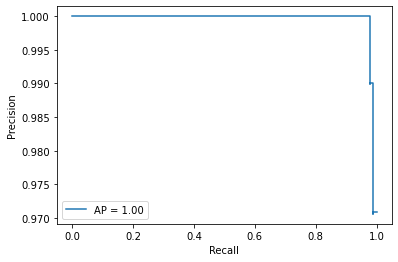

In [142]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score
X_train = clean_train + poisoned_train
y_train = clean_train_label + poisoned_train_label
X_train, y_train = shuffle(X_train,y_train, n_samples=200)
# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SVC(gamma='scale', kernel="rbf"))
clf.fit(X_train, y_train)
X_test = clean_test + poisoned_test
y_test = clean_test_label + poisoned_test_label
y_scores = clf.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

display = PrecisionRecallDisplay(
    recall=recall,
    precision=precision,
    average_precision=average_precision,
)
display.plot()
#_ = display.ax_.set_title("Micro-averaged over all classes")
plt.savefig('precision-recall-curve-mnist-rbf.pdf',format='pdf',bbox_inches = "tight")
print(thresholds)
print(len(thresholds))

In [ ]:
[-0.04899351 -0.03498825 -0.0308674  -0.03034592  0.02489305  0.10714111
  0.12374587  0.15747365  0.1702058   0.18733277  0.33067078  0.35056351
  0.3868528   0.39423861  0.41009131  0.45629529  0.49365394  0.5263316
  0.52938644  0.53744524  0.54578914  0.54601892  0.55087104  0.56560173
  0.56814673  0.56985877  0.56992128  0.60059788  0.61224492  0.61752005
  0.61817564  0.6230105   0.62812402  0.63261848  0.64131111  0.64347357
  0.66056971  0.6730232   0.67878398  0.68188051  0.69288579  0.71539745
  0.7224287   0.73845287  0.75871589  0.76882537  0.78011624  0.79017437
  0.80763369  0.81592118  0.82192636  0.83130808  0.85392196  0.86179289
  0.87158868  0.87444594  0.88310629  0.88634307  0.92419636  0.93359512
  0.94167878  0.94219819  0.94620686  0.95203447  0.95453227  0.96430725
  0.97034049  0.98487855  0.99266009  1.01499465  1.05732357  1.06192278
  1.07659559  1.08691025  1.11511299  1.14185896  1.17215789  1.18968647
  1.19389853  1.19981826  1.22748541  1.23111512  1.25787875  1.34185715
  1.34600639  1.35968593  1.42230589  1.42330981  1.44403523  1.45457653
  1.46873828  1.48016092  1.48083876  1.51219204  1.51499364  1.52255665
  1.52830443  1.54428723  1.59808726  1.69541519  1.73404769  1.7363264
  1.80842209]

# SVM linear

In [151]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.metrics import precision_score
import numpy as np
accuracy = []
recall = []
precision = []

X_train = clean_train + poisoned_train
y_train = clean_train_label + poisoned_train_label
X_train, y_train = shuffle(X_train,y_train, n_samples=600)
split_index = np.array_split(range(len(X_train)), 3)
print(len(split_index[0]))

for index in split_index:
    x_train_set = [X_train[i] for i in index]
    y_train_set = [y_train[i] for i in index]
    clf = make_pipeline(StandardScaler(),
                    SVC(gamma='scale', kernel="linear"))
    clf.fit(x_train_set, y_train_set)
    X_test = clean_test + poisoned_test
    y_test = clean_test_label + poisoned_test_label
    X_test, y_test = shuffle(X_test,y_test, n_samples=200)
    accuracy.append(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    #print(metrics.confusion_matrix(y_test,y_pred,labels=[0,1]))
    recall.append(metrics.recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))

print(accuracy)
print(recall)
print(precision)

200
[0.975, 0.995, 0.99]
[0.95, 0.99, 0.98]
[1.0, 1.0, 1.0]


In [152]:
[np.mean(accuracy),np.std(accuracy), np.min(accuracy), np.max(accuracy)]

[0.9866666666666667, 0.008498365855987981, 0.975, 0.995]

In [153]:
[np.mean(recall), np.std(recall), np.min(recall), np.max(recall)]

[0.9733333333333333, 0.016996731711975962, 0.95, 0.99]

In [154]:
[np.mean(precision),np.std(precision), np.min(precision), np.max(precision)]

[1.0, 0.0, 1.0, 1.0]

[-2.28475411 -2.27489087 -2.26120075 -2.17185292 -1.99088915 -1.95765154
 -1.61101221 -1.55513791 -1.21062766 -0.92383167 -0.79016379 -0.65073891
 -0.6485763  -0.60648889 -0.47426089 -0.31494762 -0.10172713 -0.05416477
  0.07035757  0.0856395   0.15255532  0.24912928  0.26076185  0.36368811
  0.39685914  0.59170848  0.86825406  1.17325843  1.26505888  1.34148738
  1.40992184  1.51702182  1.63378143  1.68348249  1.68939648  1.75312281
  1.77150661  1.84216188  2.03193304  2.06094182  2.06342413  2.08195965
  2.09030584  2.13258715  2.13326392  2.17848204  2.19316023  2.32273637
  2.3361398   2.40901568  2.4257307   2.42611038  2.45975005  2.48051478
  2.4836784   2.51335898  2.63462992  2.63782382  2.66984812  2.74721004
  2.78906555  2.78983542  2.79678524  2.90292576  2.96131415  2.96759491
  3.07389356  3.10967961  3.14916064  3.15462124  3.17970531  3.19378231
  3.23549364  3.2357979   3.35897444  3.41636548  3.48461798  3.50386278
  3.56867301  3.57256618  3.59187261  3.65294406  3

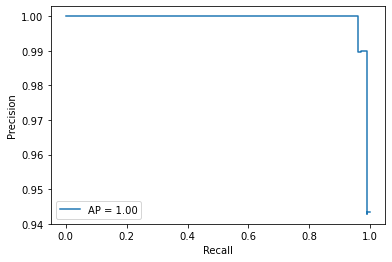

In [133]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score
X_train = clean_train + poisoned_train
y_train = clean_train_label + poisoned_train_label
X_train, y_train = shuffle(X_train,y_train, n_samples=200)
# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SVC(gamma='scale', kernel="linear"))
clf.fit(X_train, y_train)
X_test = clean_test + poisoned_test
y_test = clean_test_label + poisoned_test_label
y_scores = clf.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

display = PrecisionRecallDisplay(
    recall=recall,
    precision=precision,
    average_precision=average_precision,
)
display.plot()
#_ = display.ax_.set_title("Micro-averaged over all classes")
plt.savefig('precision-recall-curve-mnist-linear.pdf',format='pdf',bbox_inches = "tight")
print(thresholds)